## Heat content anomalies and heat budget for NAO+ and NAO- cases

Here, we examine the time evolution of heat content anomalies for selected ensemble members that had either NAO+ or NAO- conditions. The primary aims are
1. How heat content anomalies (at surface and deeper ocean) evolve over a period of 1-10 years in subpolar and subtropical regions?
2. How surface heat flux and heat convergence mediate the change in heat content?

Once we remove the model drift component, we can write the heat budget anomaly equation as

$$\rho_o C_p\int_{z}\dfrac{\partial \theta'}{\partial t} = H' - \rho_o C_p\int_{z}\nabla\cdot (\theta {\bf{u}})'$$

The first step is to create composite snapshots of heat content anomalies (maybe their tendencies) and their evolution over time.

The second step is look at timeseries of area-integrated heat budget terms (as convergence term tends to be noisy). For this, we choose two regions in the North Atlantic - 48$^{\circ}$N to 80$^{\circ}$N (or the end of North Atlantic mask) and 30$^{\circ}$N to 48$^{\circ}$N. These choices area partly based on Wiiliams et al. (2015) paper.

In [1]:
# Load libraries

import numpy as np
import math
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as mtick
#import dask
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler, ProgressBar, visualize
from dask.distributed import Client, performance_report
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings('ignore')

In [2]:
def plot_sec(ax, da, vmin=-999, vmax=999, levels=9, lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
        
    p = da.plot.contourf(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, levels = levels, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False, extend='both')
    
    # add separate colorbar
    cb = plt.colorbar(p, ax=ax, extend='both', shrink=0.6) # orientation="horizontal"
    cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    
    # parallels/meridiens
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    #gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50, -40, -30])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}

    ax.set_aspect(1.0)

    #p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=14)
    
    ax.add_feature(cfeature.LAND) #, zorder=100, edgecolor='k') #, facecolor='black')
    #ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    
    return fig, cb 

#### Read data

First read the required datafiles, which include heat budget terms, surface heat fluxes, model drift diagnostics, ocean grid cell areas, North Atlantic masks.

Also, we read data for NAO indices. The composites will selected based on NAO values.

In [16]:
# NAO seasonal data -> identify high/low NAO periods
ds_NAO = xr.open_dataset("/home/users/hkhatri/DePreSys4_Data/Data_Anomaly_Compute/NAO/NAO_SLP_Anomaly.nc")
ds_NAO = ds_NAO.isel(r=slice(0,4)) # diagnostics for all ensembles are not complete yet

NAO = ds_NAO['NAO']
tim = ds_NAO['time_val'].isel(start_year=0).drop('start_year')
NAO = NAO.assign_coords(time=tim)

NAO = NAO.isel(time=slice(1,len(NAO.time)-1)) # get rid of first Nov and last Mar for seasonal avg
%time NAO_season = NAO.resample(time='QS-DEC').mean('time')

CPU times: user 58.5 ms, sys: 3.77 ms, total: 62.3 ms
Wall time: 62.5 ms


In [23]:
NAO_cut = 2.5

count_NAOp = 0
count_NAOn = 0

for ind in range(4,13,4):
    
    c_NAOp = (xr.where(NAO_season.isel(time=ind) >= NAO_cut, 1, 0)).sum().values
    c_NAOn = (xr.where(NAO_season.isel(time=ind) <= -NAO_cut, 1, 0)).sum().values
    
    count_NAOp =  count_NAOp + c_NAOp
    count_NAOn =  count_NAOn + c_NAOn

    print('Time index = ', ind, ', NAO positive members = ', c_NAOp, ', NAO negative members = ', c_NAOn)

Time index =  4 , NAO positive members =  11 , NAO negative members =  22
Time index =  8 , NAO positive members =  21 , NAO negative members =  25
Time index =  12 , NAO positive members =  17 , NAO negative members =  22


In [24]:
print(count_NAOp, count_NAOn)

49 69


In [40]:
data_dir = "/home/users/hkhatri/DePreSys4_Data/Data_Composite/time_series/NAO/Heat_Budget/"

ds_grid = xr.open_dataset("/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/Ocean_Area_Updated.nc")

ds_mask = xr.open_dataset("/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/Mask_UVT_grid.nc")

ds_NAOp = []
ds_NAOn = [] 

count_NAOp = 0
count_NAOn = 0

for ind in range(4,13,4):
    
    c_NAOp = (xr.where(NAO_season.isel(time=ind) >= NAO_cut, 1, 0)).sum().values
    c_NAOn = (xr.where(NAO_season.isel(time=ind) <= -NAO_cut, 1, 0)).sum().values
    
    count_NAOp =  count_NAOp + c_NAOp
    count_NAOn =  count_NAOn + c_NAOn
    
    d = xr.open_dataset(data_dir + "Composite_NAOp_Heat_Budget_tim_ind_" + str(ind) + ".nc", chunks={'time':1})
                        
    d = (d.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5)) * c_NAOp).drop('time')
    
    ds_NAOp.append(d)
    
    d = xr.open_dataset(data_dir + "Composite_NAOn_Heat_Budget_tim_ind_" + str(ind) + ".nc", chunks={'time':1})
                       
    d = (d.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5)) * c_NAOn).drop('time')
    
    ds_NAOn.append(d)
    
ds_NAOp = xr.concat(ds_NAOp, dim="comp")
ds_NAOn = xr.concat(ds_NAOn, dim="comp")

ds_NAOp = ds_NAOp.sum('comp') / count_NAOp
ds_NAOn = ds_NAOn.sum('comp') / count_NAOn

ds_NAOp = xr.merge([ds_NAOp, ds_grid['area_t'].rename({'y':'j', 'x':'i'}), ds_mask.drop(['nav_lat', 'nav_lon'])])
ds_NAOp = ds_NAOp.assign(time = ds_NAO['time_val'].isel(start_year=0, time = slice((int(4/4)-1)*12, (int(4/4) + 7)*12 + 5))).drop('start_year')

ds_NAOn = xr.merge([ds_NAOn, ds_grid['area_t'].rename({'y':'j', 'x':'i'}), ds_mask.drop(['nav_lat', 'nav_lon'])])
ds_NAOn = ds_NAOn.assign(time = ds_NAO['time_val'].isel(start_year=0, time = slice((int(4/4)-1)*12, (int(4/4) + 7)*12 + 5))).drop('start_year')

In [41]:
print(ds_NAOp)

<xarray.Dataset>
Dimensions:                          (j: 450, i: 450, time: 101, j_c: 450,
                                      i_c: 450)
Coordinates:
  * j                                (j) int64 699 700 701 ... 1146 1147 1148
  * i                                (i) int64 749 750 751 ... 1196 1197 1198
    latitude                         (j, i) float32 3.997 3.997 ... 73.34 73.24
    longitude                        (j, i) float32 -99.75 -99.5 ... 51.24 51.41
    nav_lat                          (j, i) float32 3.997 3.997 ... 73.34 73.24
    nav_lon                          (j, i) float32 -99.75 -99.5 ... 51.24 51.41
  * time                             (time) object 1960-11-16 00:00:00 ... 19...
Dimensions without coordinates: j_c, i_c
Data variables: (12/14)
    Heat_Content_200                 (time, j, i) float32 dask.array<chunksize=(1, 450, 450), meta=np.ndarray>
    Heat_Content_1300                (time, j, i) float32 dask.array<chunksize=(1, 450, 450), meta=np.ndarray>
 

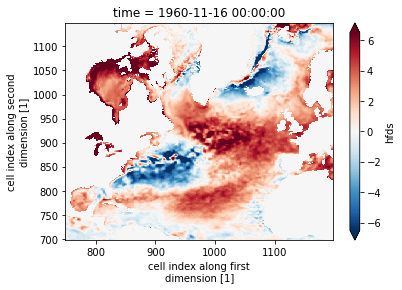

In [20]:
ds_NAOp['hfds'].isel(time=0).plot(robust=True) 

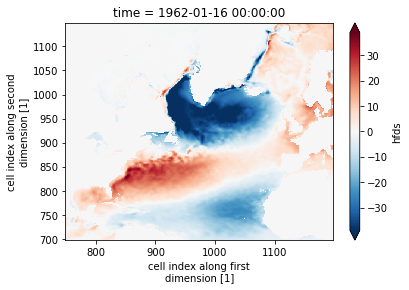

In [29]:
ds_NAOp['hfds'].isel(time=14).plot(robust=True) 

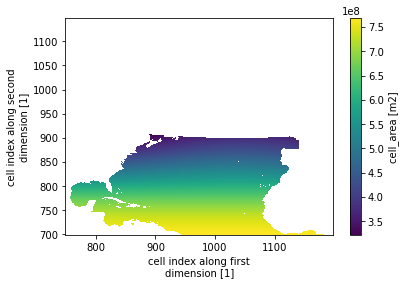

In [34]:
area_subtropics.plot()

In [7]:
tmp = ds_NAOp.get(['Heat_Content', 'Heat_Content_200', 'Heat_Content_1300'])
#dQ_dt = tmp.isel(time=slice(6, len(tmp.time), 6)).drop('time') - tmp.isel(time=slice(0, len(tmp.time)-6, 6)).drop('time')

sum_days = 30 + 31 + 31 + 28 + 31 + 30 + 31

dQ_dt = (tmp.sel(time = tmp['time.month'] == 5).drop('time') - 
         tmp.sel(time = tmp['time.month'] == 11).isel(time=slice(0,8)).drop('time')) / (sum_days *24.*3600.)

In [10]:
#tmp.sel(time = tmp['time.month'] == 5)
print(dQ_dt)

<xarray.Dataset>
Dimensions:            (j: 450, i: 450, time: 8)
Coordinates:
  * j                  (j) int64 699 700 701 702 703 ... 1145 1146 1147 1148
  * i                  (i) int64 749 750 751 752 753 ... 1195 1196 1197 1198
    latitude           (j, i) float32 3.997 3.997 3.997 ... 73.44 73.34 73.24
    longitude          (j, i) float32 -99.75 -99.5 -99.25 ... 51.08 51.24 51.41
    nav_lat            (j, i) float32 3.997 3.997 3.997 ... 73.44 73.34 73.24
    nav_lon            (j, i) float32 -99.75 -99.5 -99.25 ... 51.08 51.24 51.41
Dimensions without coordinates: time
Data variables:
    Heat_Content       (time, j, i) float32 dask.array<chunksize=(1, 450, 450), meta=np.ndarray>
    Heat_Content_200   (time, j, i) float32 dask.array<chunksize=(1, 450, 450), meta=np.ndarray>
    Heat_Content_1300  (time, j, i) float32 dask.array<chunksize=(1, 450, 450), meta=np.ndarray>


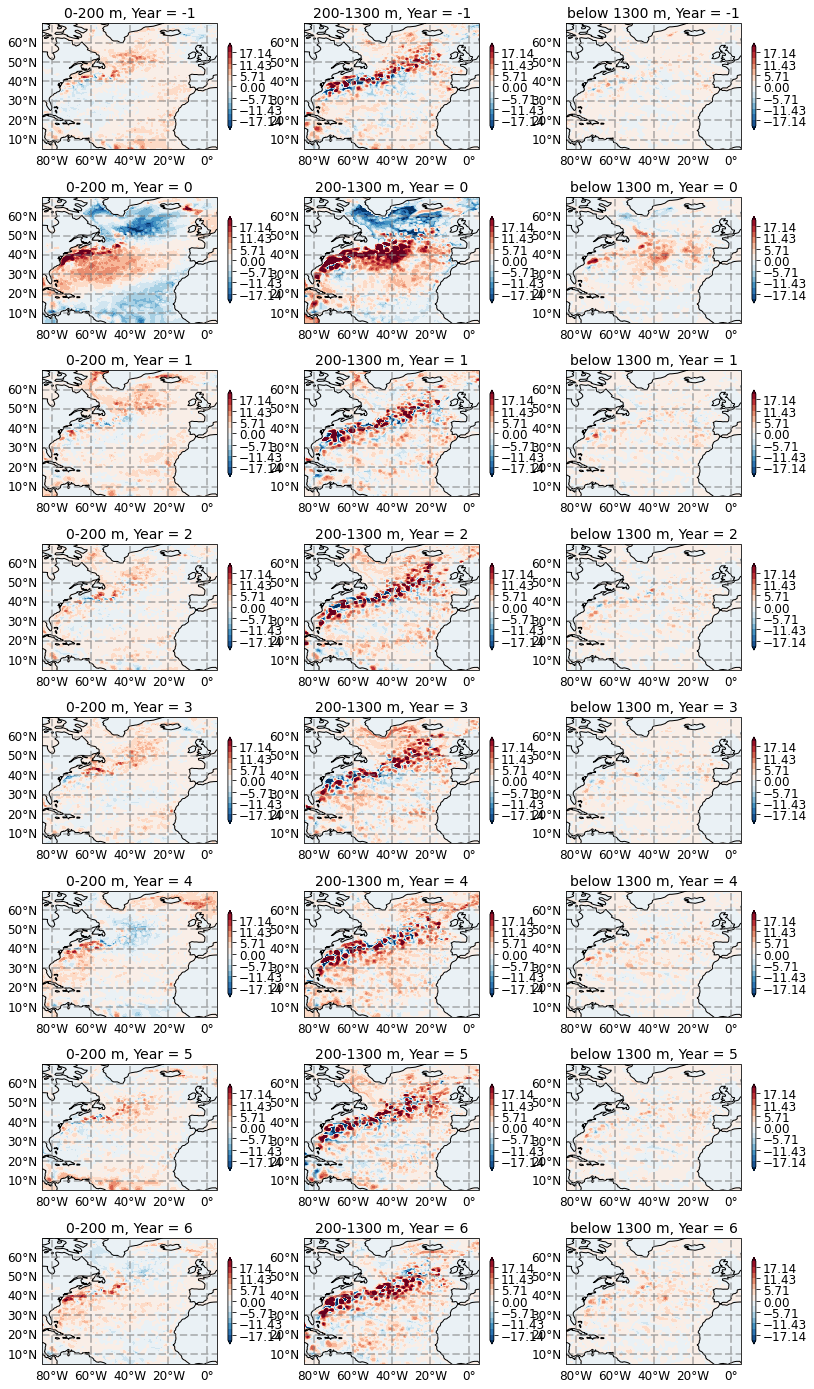

In [74]:
# Plot heat content tendency (these are bit noisy to analyse)
lat_lon_ext = [-85., 5., 5., 70.]

grid1 = plt.GridSpec(8, 4, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[18,25])

for i in range(0,8):
                 
    tmp = dQ_dt['Heat_Content_200'].isel(time=i)
    ax = fig.add_subplot(grid1[i, 0], projection=ccrs.PlateCarree(),facecolor='grey')
    [p, cb] = plot_sec(ax, tmp, vmin=-20., vmax=20.,  lat_lon_ext = lat_lon_ext, levels = 15,
                       lon='longitude', lat='latitude', cmap='RdBu_r', title='0-200 m, Year = ' + str(i-1))
    
    tmp = dQ_dt['Heat_Content_1300'].isel(time=i)
    ax = fig.add_subplot(grid1[i, 1], projection=ccrs.PlateCarree(),facecolor='grey')
    [p, cb] = plot_sec(ax, tmp, vmin=-20., vmax=20.,  lat_lon_ext = lat_lon_ext, levels = 15,
                       lon='longitude', lat='latitude', cmap='RdBu_r', title='200-1300 m, Year = ' + str(i-1))
    
    tmp = (dQ_dt['Heat_Content'] - dQ_dt['Heat_Content_1300'] - dQ_dt['Heat_Content_200']).isel(time=i)
    ax = fig.add_subplot(grid1[i, 2], projection=ccrs.PlateCarree(),facecolor='grey')
    [p, cb] = plot_sec(ax, tmp, vmin=-20., vmax=20.,  lat_lon_ext = lat_lon_ext, levels = 15,
                       lon='longitude', lat='latitude', cmap='RdBu_r', title='below 1300 m, Year = ' + str(i-1))

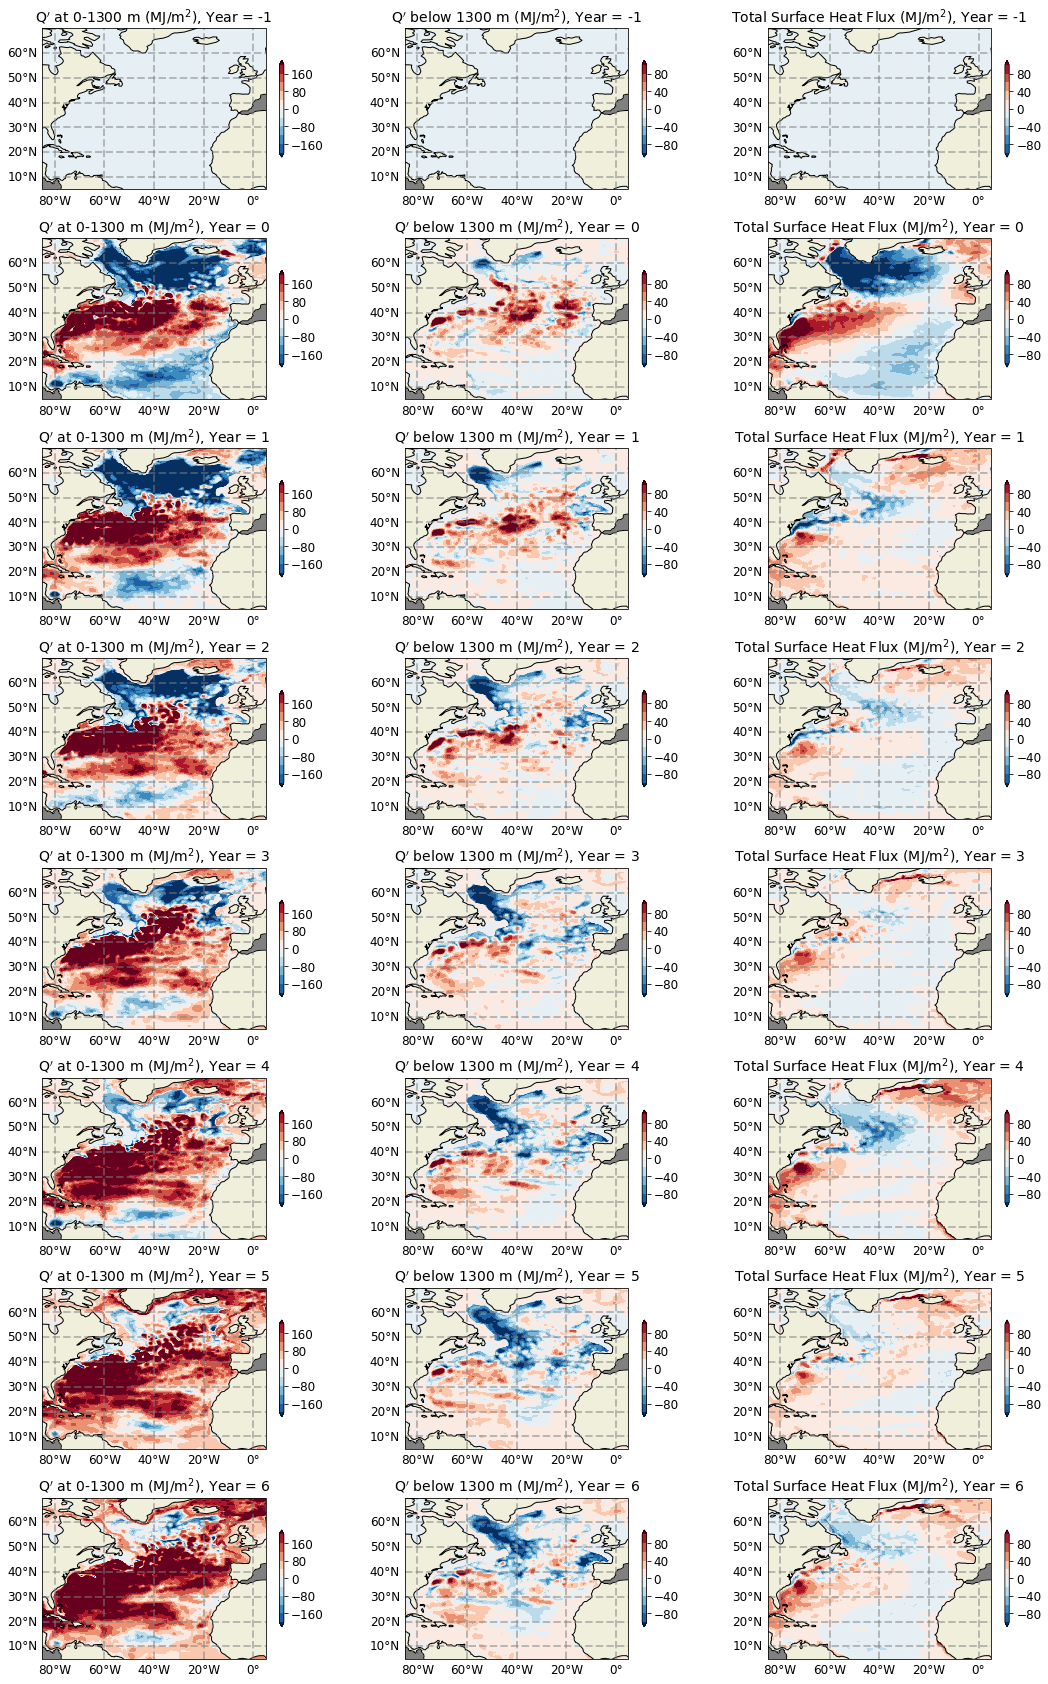

In [9]:
# Plot heat content anomalies with 12-month moving average for NAO+ case

lat_lon_ext = [-85., 5., 5., 70.]

grid1 = plt.GridSpec(8, 3, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=[18,30])

tmp_ds = ds_NAOp.rolling(time=12, center=True).mean('time')

for i in range(0,8):
                 
    tmp = ((tmp_ds['Heat_Content_200'] + tmp_ds['Heat_Content_1300']).isel(time=i*12 + 6) - 
           (tmp_ds['Heat_Content_200'] + tmp_ds['Heat_Content_1300']).isel(time=6))/1e6
    tmp = tmp.where(ds_NAOp['mask_North_Atl_t']== 0.)
    ax = fig.add_subplot(grid1[i, 0], projection=ccrs.PlateCarree(),facecolor='grey')
    [p, cb] = plot_sec(ax, tmp, vmin=-200., vmax=200.,  lat_lon_ext = lat_lon_ext, levels = 11,
                       lon='longitude', lat='latitude', cmap='RdBu_r', title=r'Q$^{\prime}$ at 0-1300 m (MJ/m$^2$), Year = ' + str(i-1))
    
    tmp = ((tmp_ds['Heat_Content'] - tmp_ds['Heat_Content_1300'] - tmp_ds['Heat_Content_200']).isel(time=i*12 + 6) -
           (tmp_ds['Heat_Content'] - tmp_ds['Heat_Content_1300'] - tmp_ds['Heat_Content_200']).isel(time=6))/1e6
    tmp = tmp.where(ds_NAOp['mask_North_Atl_t']== 0.)
    ax = fig.add_subplot(grid1[i, 1], projection=ccrs.PlateCarree(),facecolor='grey')
    [p, cb] = plot_sec(ax, tmp, vmin=-100., vmax=100.,  lat_lon_ext = lat_lon_ext, levels = 11,
                       lon='longitude', lat='latitude', cmap='RdBu_r', title=r'Q$^{\prime}$ below 1300 m (MJ/m$^2$), Year = ' + str(i-1))
    
    #tmp = tmp_ds['hfds'].isel(time=i*12 + 6)
    tmp = (ds_NAOp['hfds'].isel(time=slice(int(i*12), int(i*12 + 6 + 6))).sum('time') * 12 
           - ds_NAOp['hfds'].isel(time=slice(0, 12)).sum('time') * 12) * 3600. * 24. /1e6 # heat flux integrated within a year
    tmp = tmp.where(ds_NAOp['mask_North_Atl_t']== 0.)
    ax = fig.add_subplot(grid1[i, 2], projection=ccrs.PlateCarree(),facecolor='grey')
    [p, cb] = plot_sec(ax, tmp, vmin=-100., vmax=100.,  lat_lon_ext = lat_lon_ext, levels = 11,
                       lon='longitude', lat='latitude', cmap='RdBu_r', title=r'Total Surface Heat Flux (MJ/m$^2$), Year = ' + str(i-1))
    
fig.savefig('/home/users/hkhatri/Plots/Figures_EGU_2022/Snapshot_NAOplus_Heat_content.pdf',
            dpi=150,bbox_inches='tight');

In [93]:
# Area integrated heat-content and heat budget analysis within regions

ds_45N_70N = xr.Dataset()
ds_20N_45N = xr.Dataset()

dA_45N_70N = ds_NAOp['area_t'].where((ds_NAOp['mask_North_Atl_t'] == 0.) & (ds_NAOp['latitude'] >=45.) &
                                    (ds_NAOp['latitude'] < 65.))

dA_20N_45N = ds_NAOp['area_t'].where((ds_NAOp['mask_North_Atl_t'] == 0.) & (ds_NAOp['latitude'] < 45.)
                                     & (ds_NAOp['latitude'] >= 25.))

var_list = ['Heat_Content', 'Heat_Content_200', 'Heat_Content_1300']
dt = 30. * 24 * 3600.

#for var in var_list:
    
%time ds_45N_70N = (ds_NAOp * dA_45N_70N).sum(['i', 'j']).compute()
%time ds_20N_45N = (ds_NAOp * dA_20N_45N).sum(['i', 'j']).compute()

CPU times: user 11.2 s, sys: 4.78 s, total: 16 s
Wall time: 12.8 s
CPU times: user 9.8 s, sys: 3.78 s, total: 13.6 s
Wall time: 8.4 s


In [57]:
print(ds_45N_70N)

<xarray.Dataset>
Dimensions:                          (time: 101, j_c: 450, i_c: 450)
Coordinates:
  * time                             (time) object 1960-11-16 00:00:00 ... 19...
Dimensions without coordinates: j_c, i_c
Data variables: (12/14)
    Heat_Content_200                 (time) float32 -3.422e+20 ... 5.347e+20
    Heat_Content_1300                (time) float32 3.94e+20 ... 8.38e+20
    Heat_Content                     (time) float32 8.788e+20 ... 1.708e+21
    Heat_Divergence_Horizontal_200   (time) float32 -1.792e+13 ... 2.242e+13
    Heat_Divergence_Horizontal_1300  (time) float32 8.779e+12 ... 1.057e+13
    Heat_Divergence_Horizontal       (time) float32 4.218e+12 ... 4.706e+13
    ...                               ...
    Heat_Divergence_Vertical         (time) float32 4.65e+12 ... 4.415e+13
    hfds                             (time) float32 5.863e+13 ... 2.309e+13
    area_t                           float32 2.802e+21
    mask_North_Atl_v                 (j_c) float64 

Text(0.5, 1.0, '$25^{\\circ}N-45^{\\circ}N$ at z = 0-1300 m')

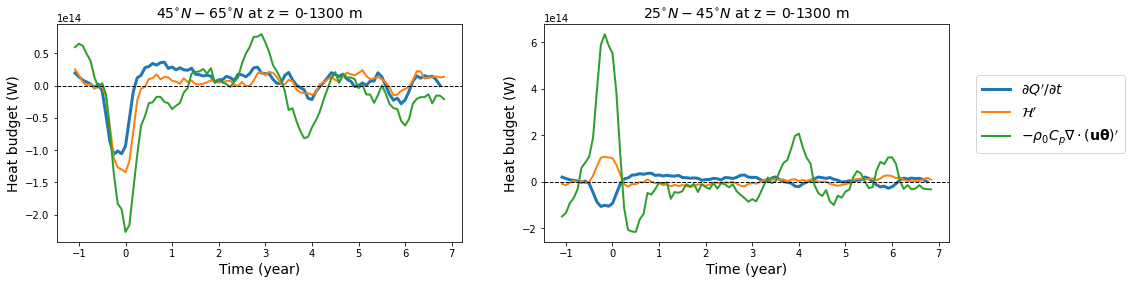

In [94]:
grid1 = plt.GridSpec(1, 2, wspace=0.2, hspace=0.4)
fig = plt.figure(figsize=[16,4])

ax = fig.add_subplot(grid1[0, 0])

HF = ds_45N_70N['hfds'].rolling(time=6, center=True).mean('time')
Hor_flx = - (ds_45N_70N['Heat_Divergence_Horizontal_200'] + ds_45N_70N['Heat_Divergence_Horizontal_1300']).rolling(time=6, center=True).mean('time')
Ver_flx = - (ds_45N_70N['Heat_Divergence_Vertical_200'] + ds_45N_70N['Heat_Divergence_Vertical_200']).rolling(time=6, center=True).mean('time')
Q = (ds_45N_70N['Heat_Content_200'].diff('time') / dt).rolling(time=6, center=True).mean('time')
#Q = HF + Hor_flx + Ver_flx

ax.plot(np.arange(len(Q.time))/12 - 16/12, Q, lw = 3., label=r'$\int_A\partial Q^{\prime}/\partial t$')
ax.plot(np.arange(len(HF.time))/12 - 16/12, HF, lw = 2.,  label=r'$\int_A\mathcal{H}^{\prime}$')
ax.plot(np.arange(len(HF.time))/12 - 16/12, Hor_flx + Ver_flx, lw = 2.,  label=r'$-\rho_0C_p\int_A\nabla\cdot({\bf{u}\theta})^{\prime}$')
#ax.plot(np.arange(len(Q.time))/12 - 16/12, Ver_flx, lw = 2.,  label=r'$-\rho_0C_p\int_A\partial ({w\theta})^{\prime}/\partial z$')

#ax.plot(HF - Hor_flx - Ver_flx)

ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_xlabel('Time (year)', fontsize=14)
ax.set_ylabel('Heat budget (W)', fontsize=14)
plt.title(r'$45^{\circ}N-65^{\circ}N$ at z = 0-1300 m', fontsize=14)

ax = fig.add_subplot(grid1[0, 1])

HF = ds_20N_45N['hfds'].rolling(time=6, center=True).mean('time')
Hor_flx = - (ds_20N_45N['Heat_Divergence_Horizontal_200'] + ds_20N_45N['Heat_Divergence_Horizontal_1300']).rolling(time=6, center=True).mean('time')
Ver_flx = - (ds_20N_45N['Heat_Divergence_Vertical_200'] + ds_20N_45N['Heat_Divergence_Vertical_200']).rolling(time=6, center=True).mean('time')
Q = (ds_45N_70N['Heat_Content_200'].diff('time') / dt).rolling(time=6, center=True).mean('time')
#Q = HF + Hor_flx + Ver_flx

ax.plot(np.arange(len(Q.time))/12 - 16/12, Q, lw = 3., label=r'$\partial Q^{\prime}/\partial t$')
ax.plot(np.arange(len(HF.time))/12 - 16/12, HF, lw = 2.,  label=r'$\mathcal{H}^{\prime}$')
ax.plot(np.arange(len(HF.time))/12 - 16/12, Hor_flx + Ver_flx, lw = 2.,  label=r'$-\rho_0C_p\nabla\cdot({\bf{u}\theta})^{\prime}$')
#ax.plot(np.arange(len(Q.time))/12 - 16/12, Ver_flx, lw = 2.,  label=r'$-\rho_0C_p\partial ({w\theta})^{\prime}/\partial z$')

#ax.plot(HF - Hor_flx - Ver_flx)

ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_xlabel('Time (year)', fontsize=14)
ax.set_ylabel('Heat budget (W)', fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 0.8), fontsize=14)
plt.title(r'$25^{\circ}N-45^{\circ}N$ at z = 0-1300 m', fontsize=14)

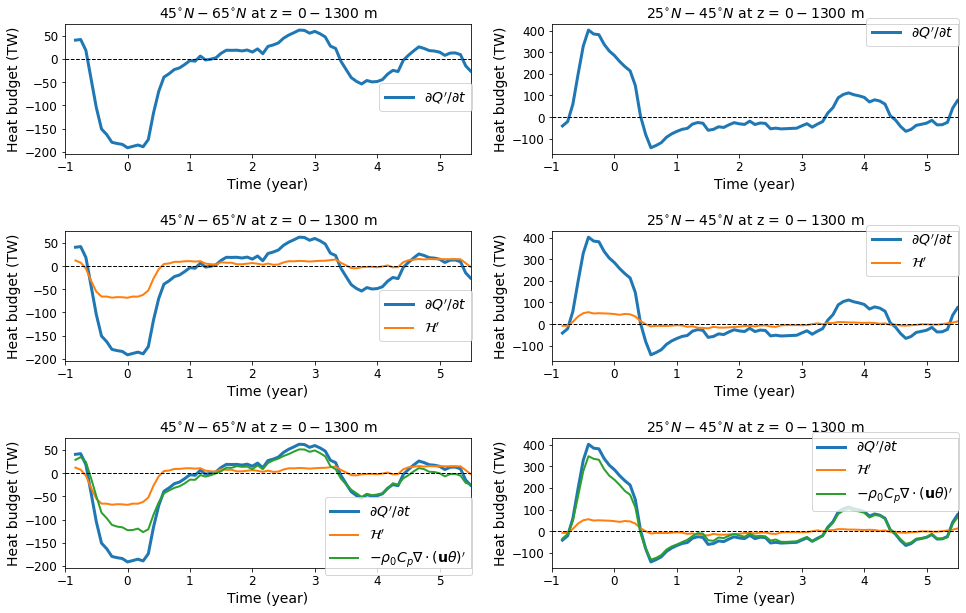

In [45]:
grid1 = plt.GridSpec(3, 2, wspace=0.2, hspace=0.6)
fig = plt.figure(figsize=[16,10])

HF = ds_45N_70N['hfds'].rolling(time=12, center=True).mean('time') / 1e12
Hor_flx = - (ds_45N_70N['Heat_Divergence_Horizontal_200'] + 
            ds_45N_70N['Heat_Divergence_Horizontal_1300']).rolling(time=12, center=True).mean('time') / 1e12
Ver_flx = - (ds_45N_70N['Heat_Divergence_Vertical_200'] + 
            ds_45N_70N['Heat_Divergence_Vertical_200']).rolling(time=12, center=True).mean('time') / 1e12
Q = HF + Hor_flx + Ver_flx

for i in range(0,3):
    ax = fig.add_subplot(grid1[i, 0])

    ax.plot(np.arange(len(Q.time))/12 - 16/12, Q, lw = 3., label=r'$\partial Q^{\prime}/\partial t$')
    
    if(i>0):
        ax.plot(np.arange(len(Q.time))/12 - 16/12, HF, lw = 2.,  
                label=r'$\mathcal{H}^{\prime}$')
    
    if(i>1):
        ax.plot(np.arange(len(Q.time))/12 - 16/12, Hor_flx + Ver_flx, lw = 2.,  
                label=r'$-\rho_0C_p\nabla\cdot({\bf{u}}\theta)^{\prime}$')
        
    ax.axhline(y=0, ls='--', lw=1, color='k')
    ax.set_xlabel('Time (year)', fontsize=14)
    ax.set_ylabel('Heat budget (TW)', fontsize=14)
    plt.legend(loc='upper right', bbox_to_anchor=(1.02, 0.6), fontsize=14)
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.title(r'$45^{\circ}N-65^{\circ}N$ at z = $0-1300$ m', fontsize=14)
    ax.set_xlim([-1., 5.5])
    
HF = ds_20N_45N['hfds'].rolling(time=12, center=True).mean('time') / 1e12
Hor_flx = - (ds_20N_45N['Heat_Divergence_Horizontal_200'] + 
            ds_20N_45N['Heat_Divergence_Horizontal_1300']).rolling(time=12, center=True).mean('time') / 1e12
Ver_flx = - (ds_20N_45N['Heat_Divergence_Vertical_200'] + 
            ds_20N_45N['Heat_Divergence_Vertical_200']).rolling(time=12, center=True).mean('time') / 1e12
Q = HF + Hor_flx + Ver_flx

for i in range(0,3):
    ax = fig.add_subplot(grid1[i, 1])

    ax.plot(np.arange(len(Q.time))/12 - 16/12, Q, lw = 3., label=r'$\partial Q^{\prime}/\partial t$')
    
    if(i>0):
        ax.plot(np.arange(len(Q.time))/12 - 16/12, HF, lw = 2.,  
                label=r'$\mathcal{H}^{\prime}$')
    
    if(i>1):
        ax.plot(np.arange(len(Q.time))/12 - 16/12, Hor_flx + Ver_flx, lw = 2.,  
                label=r'$-\rho_0C_p\nabla\cdot({\bf{u}}\theta)^{\prime}$')
        
    ax.axhline(y=0, ls='--', lw=1, color='k')
    ax.set_xlabel('Time (year)', fontsize=14)
    ax.set_ylabel('Heat budget (TW)', fontsize=14)
    plt.legend(loc='upper right', bbox_to_anchor=(1.02, 1.1), fontsize=14)
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.title(r'$25^{\circ}N-45^{\circ}N$ at z = $0-1300$ m', fontsize=14)
    ax.set_xlim([-1., 5.5])
    
#fig.savefig('/home/users/hkhatri/Plots/Figures_EGU_2022/Timeseries_NAOplus_Heat_content.pdf', dpi=150, bbox_inches='tight');

fig.savefig('/home/users/hkhatri/Plots/Figures_EGU_2022/Timeseries_NAOplus_Heat_content.png', dpi=300, bbox_inches='tight');

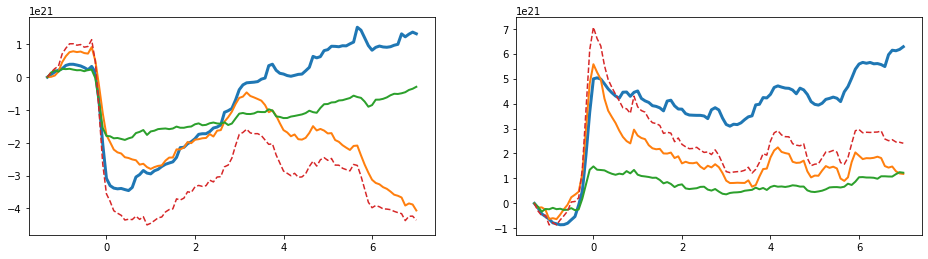

In [69]:
grid1 = plt.GridSpec(1, 2, wspace=0.2, hspace=0.6)
fig = plt.figure(figsize=[16,4])

ax = fig.add_subplot(grid1[0, 0])

Q = (ds_45N_70N['Heat_Content_200'] + ds_45N_70N['Heat_Content_1300'])

Heat_conv = (-(ds_45N_70N['Heat_Divergence_Horizontal_200'] + ds_45N_70N['Heat_Divergence_Horizontal_1300'] +
               ds_45N_70N['Heat_Divergence_Vertical_200'] + ds_45N_70N['Heat_Divergence_Vertical_1300']).cumsum('time') * 30*3600.*24)

HF = ds_45N_70N['hfds'].cumsum('time') * 30*3600.*24

ax.plot(np.arange(len(Q.time))/12 - 16/12, Q - Q.isel(time=0), lw = 3., label=r'$Q^{\prime}$')
ax.plot(np.arange(len(Q.time))/12 - 16/12, Heat_conv - Heat_conv.isel(time=0), lw = 2.,  
        label=r'$-\rho_0C_p\int_{t_o}^{t}\nabla\cdot({\bf{u}}\theta)^{\prime} dt$')
ax.plot(np.arange(len(Q.time))/12 - 16/12, HF - HF.isel(time=0), lw = 2.,  label=r'$\int_{t_o}^{t} \mathcal{H}^{\prime} dt$')

ax.plot(np.arange(len(Q.time))/12 - 16/12, Heat_conv - Heat_conv.isel(time=0) + HF - HF.isel(time=0), ls='--'); 

ax = fig.add_subplot(grid1[0, 1])

Q = (ds_20N_45N['Heat_Content_200'] + ds_20N_45N['Heat_Content_1300'])

Heat_conv = (-(ds_20N_45N['Heat_Divergence_Horizontal_200'] + ds_20N_45N['Heat_Divergence_Horizontal_1300'] +
               ds_20N_45N['Heat_Divergence_Vertical_200'] + ds_20N_45N['Heat_Divergence_Vertical_1300']).cumsum('time') * 30*3600.*24)

HF = ds_20N_45N['hfds'].cumsum('time') * 30*3600.*24

ax.plot(np.arange(len(Q.time))/12 - 16/12, Q - Q.isel(time=0), lw = 3., label=r'$Q^{\prime}$')
ax.plot(np.arange(len(Q.time))/12 - 16/12, Heat_conv - Heat_conv.isel(time=0), lw = 2.,  
        label=r'$-\rho_0C_p\int_{t_o}^{t}\nabla\cdot({\bf{u}}\theta)^{\prime} dt$')
ax.plot(np.arange(len(Q.time))/12 - 16/12, HF - HF.isel(time=0), lw = 2.,  label=r'$\int_{t_o}^{t} \mathcal{H}^{\prime} dt$')

ax.plot(np.arange(len(Q.time))/12 - 16/12, Heat_conv - Heat_conv.isel(time=0) + HF - HF.isel(time=0), ls='--'); 

Text(0.5, 1.0, '$25^{\\circ}N-45^{\\circ}N$ at z below 1300 m')

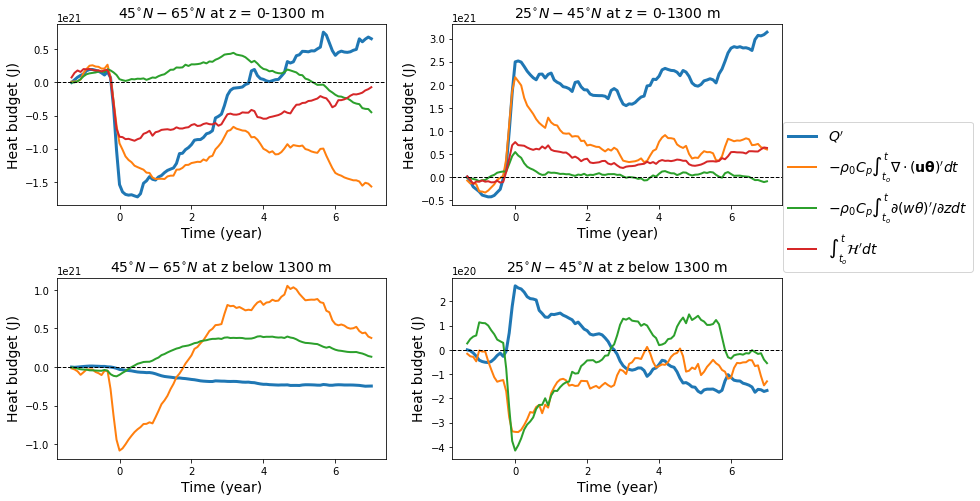

In [62]:
grid1 = plt.GridSpec(2, 2, wspace=0.2, hspace=0.4)
fig = plt.figure(figsize=[13,8])

ax = fig.add_subplot(grid1[0, 0])

Q = (ds_45N_70N['Heat_Content_200'] + ds_45N_70N['Heat_Content_1300'])
ax.plot(np.arange(len(Q.time))/12 - 16/12, Q- Q.isel(time=0), lw = 3., label=r'$Q^{\prime}$')

Hor_flx = - (ds_45N_70N['Heat_Divergence_Horizontal_200'] + 
             ds_45N_70N['Heat_Divergence_Horizontal_1300']).cumsum('time') * 30*3600.*24
ax.plot(np.arange(len(Q.time))/12 - 16/12, Hor_flx, lw = 2.,  label=r'$-\rho_0C_p\int_{t_o}^{t}\nabla\cdot({\bf{u}\theta})^{\prime} dt$')

Ver_flx = - (ds_45N_70N['Heat_Divergence_Vertical_200'] + 
             ds_45N_70N['Heat_Divergence_Vertical_1300']).cumsum('time') * 30*3600.*24
ax.plot(np.arange(len(Q.time))/12 - 16/12, Ver_flx, lw = 2.,  label=r'$-\rho_0C_p\int_{t_o}^{t}\partial ({w\theta})^{\prime}/\partial z dt$')

HF = ds_45N_70N['hfds'].cumsum('time') * 30*3600.*24
ax.plot(np.arange(len(Q.time))/12 - 16/12, HF, lw = 2.,  label=r'$\int_{t_o}^{t} \mathcal{H}^{\prime} dt$')

#ax.plot(HF - Hor_flx - Ver_flx)

ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_xlabel('Time (year)', fontsize=14)
ax.set_ylabel('Heat budget (J)', fontsize=14)
#plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=14)
plt.title(r'$45^{\circ}N-65^{\circ}N$ at z = 0-1300 m', fontsize=14)

ax = fig.add_subplot(grid1[1, 0])

Q = (ds_45N_70N['Heat_Content'] - ds_45N_70N['Heat_Content_1300'] - ds_45N_70N['Heat_Content_200'])
ax.plot(np.arange(len(Q.time))/12 - 16/12, Q- Q.isel(time=0), lw = 3., label=r'$\int_A\partial Q^{\prime}/\partial t$')

Hor_flx = - (ds_45N_70N['Heat_Divergence_Horizontal'] - ds_45N_70N['Heat_Divergence_Horizontal_1300']
            - ds_45N_70N['Heat_Divergence_Horizontal_200']).cumsum('time') * 30*3600.*24
ax.plot(np.arange(len(Q.time))/12 - 16/12, Hor_flx, lw = 2.,  label=r'$-\rho_0C_p\int_A\nabla\cdot({\bf{u}\theta})^{\prime}$')

Ver_flx = - (ds_45N_70N['Heat_Divergence_Vertical'] - ds_45N_70N['Heat_Divergence_Vertical_1300'] -
            ds_45N_70N['Heat_Divergence_Vertical_200']).cumsum('time') * 30*3600.*24
ax.plot(np.arange(len(Q.time))/12 - 16/12, Ver_flx, lw = 2.,  label=r'$-\rho_0C_p\int_A\partial ({w\theta})^{\prime}/\partial z$')

#ax.plot(HF + Hor_flx + Ver_flx)

ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_xlabel('Time (year)', fontsize=14)
ax.set_ylabel('Heat budget (J)', fontsize=14)
#plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=14)
plt.title(r'$45^{\circ}N-65^{\circ}N$ at z below 1300 m', fontsize=14)

ax = fig.add_subplot(grid1[0, 1])

Q = (ds_20N_45N['Heat_Content_200'] + ds_20N_45N['Heat_Content_1300'])
ax.plot(np.arange(len(Q.time))/12 - 16/12, Q- Q.isel(time=0), lw = 3., label=r'$Q^{\prime}$')

Hor_flx = - (ds_20N_45N['Heat_Divergence_Horizontal_200'] + 
             ds_20N_45N['Heat_Divergence_Horizontal_1300']).cumsum('time') * 30*3600.*24
ax.plot(np.arange(len(Q.time))/12 - 16/12, Hor_flx, lw = 2.,  label=r'$-\rho_0C_p\int_{t_o}^{t}\nabla\cdot({\bf{u}\theta})^{\prime} dt$')

Ver_flx = - (ds_20N_45N['Heat_Divergence_Vertical_200'] + 
             ds_20N_45N['Heat_Divergence_Vertical_1300']).cumsum('time') * 30*3600.*24
ax.plot(np.arange(len(Q.time))/12 - 16/12, Ver_flx, lw = 2.,  label=r'$-\rho_0C_p\int_{t_o}^{t}\partial ({w\theta})^{\prime}/\partial z dt$')

HF = ds_20N_45N['hfds'].cumsum('time') * 30*3600.*24
ax.plot(np.arange(len(Q.time))/12 - 16/12, HF, lw = 2.,  label=r'$\int_{t_o}^{t} \mathcal{H}^{\prime} dt$')

#ax.plot(HF - Hor_flx - Ver_flx)

ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_xlabel('Time (year)', fontsize=14)
ax.set_ylabel('Heat budget (J)', fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.6, 0.5), fontsize=14)
plt.title(r'$25^{\circ}N-45^{\circ}N$ at z = 0-1300 m', fontsize=14)

ax = fig.add_subplot(grid1[1, 1])

Q = (ds_20N_45N['Heat_Content'] - ds_20N_45N['Heat_Content_1300'] - ds_20N_45N['Heat_Content_200'])
ax.plot(np.arange(len(Q.time))/12 - 16/12, Q - Q.isel(time=0), lw = 3., label=r'$\int_A\partial Q^{\prime}/\partial t$')

Hor_flx = - (ds_20N_45N['Heat_Divergence_Horizontal'] - ds_20N_45N['Heat_Divergence_Horizontal_1300']
            - ds_20N_45N['Heat_Divergence_Horizontal_200']).cumsum('time') * 30*3600.*24
ax.plot(np.arange(len(Q.time))/12 - 16/12, Hor_flx, lw = 2.,  label=r'$-\rho_0C_p\int_A\nabla\cdot({\bf{u}\theta})^{\prime}$')

Ver_flx = - (ds_20N_45N['Heat_Divergence_Vertical'] - ds_20N_45N['Heat_Divergence_Vertical_1300'] -
            ds_20N_45N['Heat_Divergence_Vertical_200']).cumsum('time') * 30*3600.*24
ax.plot(np.arange(len(Q.time))/12 - 16/12, Ver_flx, lw = 2.,  label=r'$-\rho_0C_p\int_A\partial ({w\theta})^{\prime}/\partial z$')

#ax.plot(HF + Hor_flx + Ver_flx)

ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_xlabel('Time (year)', fontsize=14)
ax.set_ylabel('Heat budget (J)', fontsize=14)
#plt.legend(loc='lower right', fontsize=14)
plt.title(r'$25^{\circ}N-45^{\circ}N$ at z below 1300 m', fontsize=14)

In [154]:
np.arange(len(Q.time))/12 - 16/12

array([-1.33333333, -1.25      , -1.16666667, -1.08333333, -1.        ,
       -0.91666667, -0.83333333, -0.75      , -0.66666667, -0.58333333,
       -0.5       , -0.41666667, -0.33333333, -0.25      , -0.16666667,
       -0.08333333,  0.        ,  0.08333333,  0.16666667,  0.25      ,
        0.33333333,  0.41666667,  0.5       ,  0.58333333,  0.66666667,
        0.75      ,  0.83333333,  0.91666667,  1.        ,  1.08333333,
        1.16666667,  1.25      ,  1.33333333,  1.41666667,  1.5       ,
        1.58333333,  1.66666667,  1.75      ,  1.83333333,  1.91666667,
        2.        ,  2.08333333,  2.16666667,  2.25      ,  2.33333333,
        2.41666667,  2.5       ,  2.58333333,  2.66666667,  2.75      ,
        2.83333333,  2.91666667,  3.        ,  3.08333333,  3.16666667,
        3.25      ,  3.33333333,  3.41666667,  3.5       ,  3.58333333,
        3.66666667,  3.75      ,  3.83333333,  3.91666667,  4.        ,
        4.08333333,  4.16666667,  4.25      ,  4.33333333,  4.41

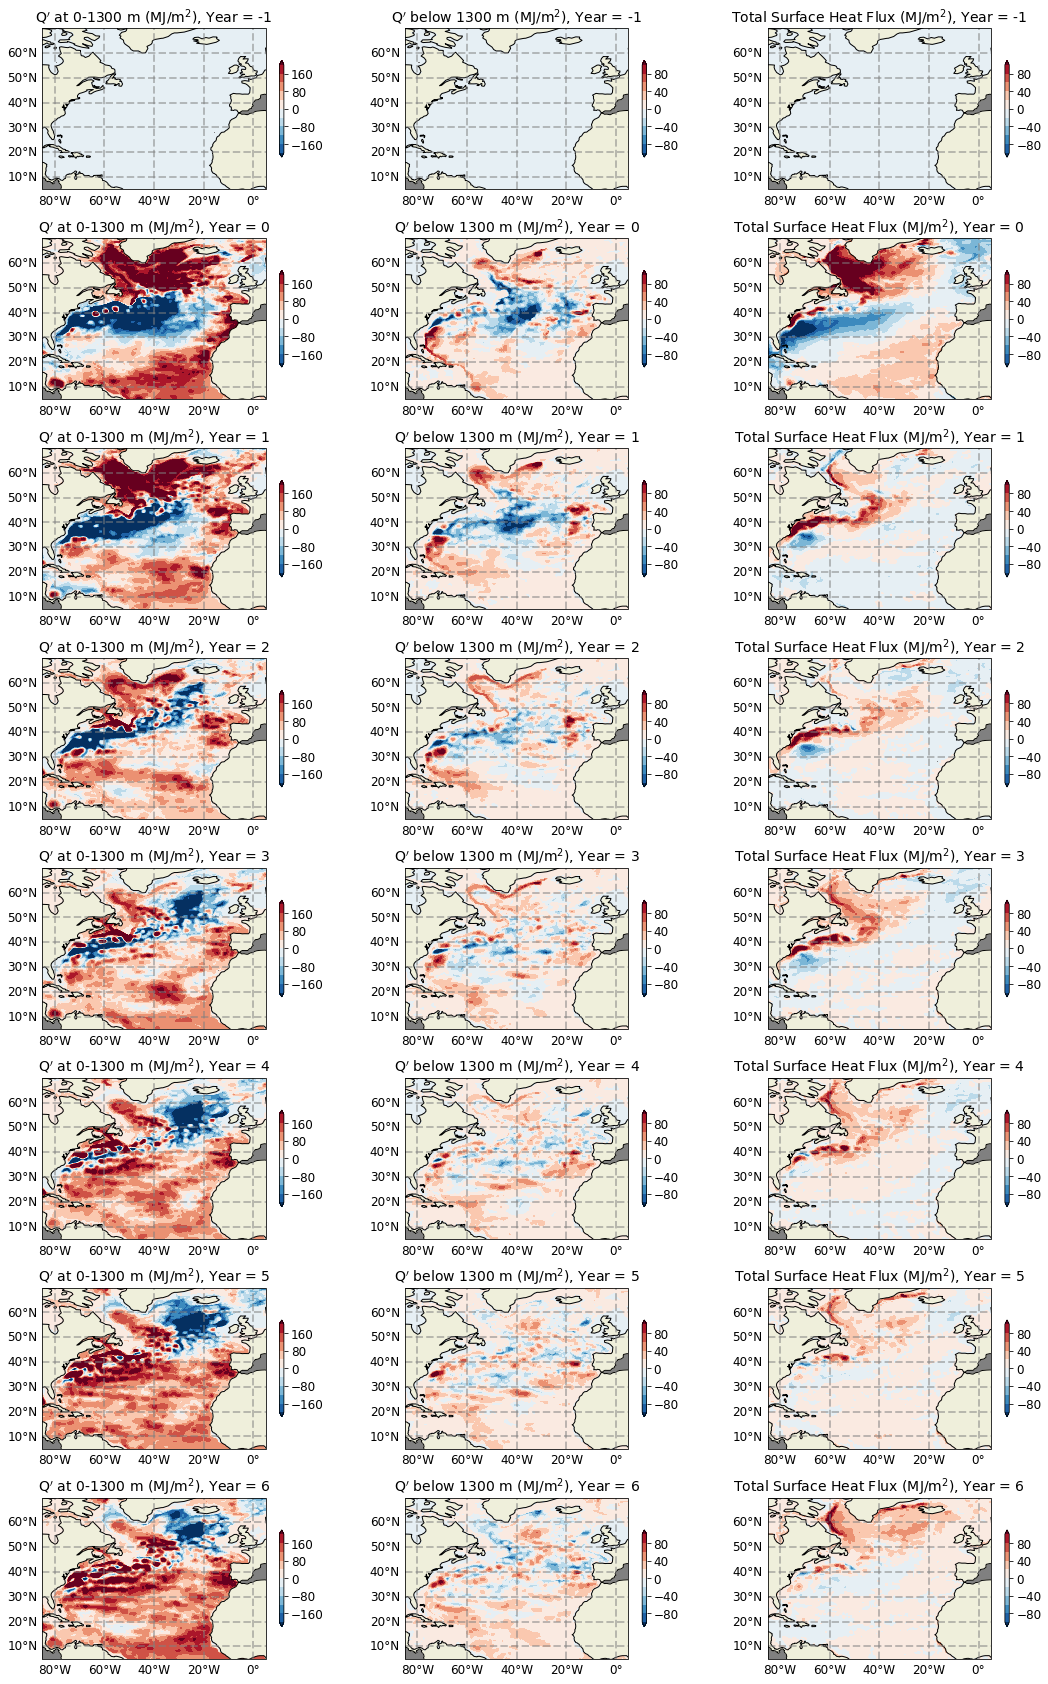

In [10]:
# Plot heat content anomalies with 12-month moving average for NAO- case

lat_lon_ext = [-85., 5., 5., 70.]

grid1 = plt.GridSpec(8, 3, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=[18,30])

tmp_ds = ds_NAOn.rolling(time=12, center=True).mean('time')

for i in range(0,8):
                 
    tmp = ((tmp_ds['Heat_Content_200'] + tmp_ds['Heat_Content_1300']).isel(time=i*12 + 6) - 
           (tmp_ds['Heat_Content_200'] + tmp_ds['Heat_Content_1300']).isel(time=6))/1e6
    tmp = tmp.where(ds_NAOp['mask_North_Atl_t']== 0.)
    ax = fig.add_subplot(grid1[i, 0], projection=ccrs.PlateCarree(),facecolor='grey')
    [p, cb] = plot_sec(ax, tmp, vmin=-200., vmax=200.,  lat_lon_ext = lat_lon_ext, levels = 11,
                       lon='longitude', lat='latitude', cmap='RdBu_r', title=r'Q$^{\prime}$ at 0-1300 m (MJ/m$^2$), Year = ' + str(i-1))
    
    tmp = ((tmp_ds['Heat_Content'] - tmp_ds['Heat_Content_1300'] - tmp_ds['Heat_Content_200']).isel(time=i*12 + 6) -
           (tmp_ds['Heat_Content'] - tmp_ds['Heat_Content_1300'] - tmp_ds['Heat_Content_200']).isel(time=6))/1e6
    tmp = tmp.where(ds_NAOp['mask_North_Atl_t']== 0.)
    ax = fig.add_subplot(grid1[i, 1], projection=ccrs.PlateCarree(),facecolor='grey')
    [p, cb] = plot_sec(ax, tmp, vmin=-100., vmax=100.,  lat_lon_ext = lat_lon_ext, levels = 11,
                       lon='longitude', lat='latitude', cmap='RdBu_r', title=r'Q$^{\prime}$ below 1300 m (MJ/m$^2$), Year = ' + str(i-1))
    
    #tmp = tmp_ds['hfds'].isel(time=i*12 + 6)
    tmp = (ds_NAOn['hfds'].isel(time=slice(int(i*12), int(i*12 + 6 + 6))).sum('time') * 12 
           - ds_NAOn['hfds'].isel(time=slice(0, 12)).sum('time') * 12) * 3600. * 24. /1e6 # heat flux integrated within a year
    tmp = tmp.where(ds_NAOp['mask_North_Atl_t']== 0.)
    ax = fig.add_subplot(grid1[i, 2], projection=ccrs.PlateCarree(),facecolor='grey')
    [p, cb] = plot_sec(ax, tmp, vmin=-100., vmax=100.,  lat_lon_ext = lat_lon_ext, levels = 11,
                       lon='longitude', lat='latitude', cmap='RdBu_r', title=r'Total Surface Heat Flux (MJ/m$^2$), Year = ' + str(i-1))
    
fig.savefig('/home/users/hkhatri/Plots/Figures_EGU_2022/Snapshot_NAOminus_Heat_content.pdf',
            dpi=150,bbox_inches='tight');

In [89]:
# Area integrated heat-content and heat budget analysis within regions

ds_45N_70N = xr.Dataset()
ds_20N_45N = xr.Dataset()

dA_45N_70N = ds_NAOn['area_t'].where((ds_NAOn['mask_North_Atl_t'] == 0.) & (ds_NAOn['latitude'] >=45.) &
                                    (ds_NAOn['latitude'] < 65.))

dA_20N_45N = ds_NAOn['area_t'].where((ds_NAOn['mask_North_Atl_t'] == 0.) & (ds_NAOn['latitude'] < 45.)
                                     & (ds_NAOn['latitude'] >= 25.))

var_list = ['Heat_Content', 'Heat_Content_200', 'Heat_Content_1300']
dt = 30. * 24 * 3600.

#for var in var_list:
    
%time ds_45N_70N = (ds_NAOn * dA_45N_70N).sum(['i', 'j']).compute()
%time ds_20N_45N = (ds_NAOn * dA_20N_45N).sum(['i', 'j']).compute()

CPU times: user 10.6 s, sys: 3.47 s, total: 14 s
Wall time: 8.45 s
CPU times: user 10.1 s, sys: 3.25 s, total: 13.4 s
Wall time: 8.02 s


Text(0.5, 1.0, '$25^{\\circ}N-45^{\\circ}N$ at z = 0-1300 m')

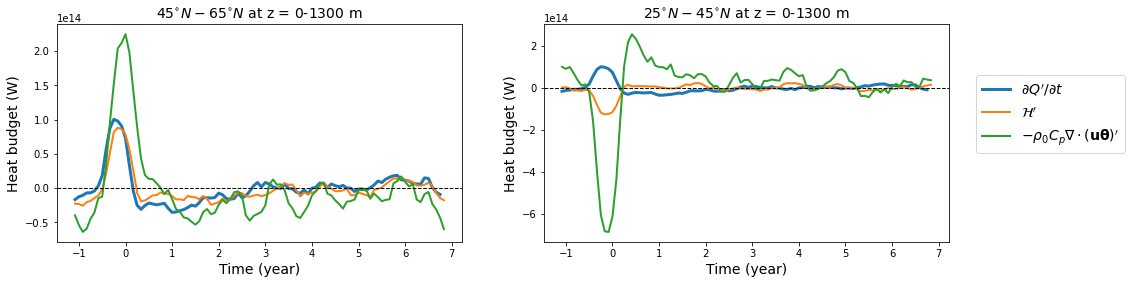

In [92]:
grid1 = plt.GridSpec(1, 2, wspace=0.2, hspace=0.4)
fig = plt.figure(figsize=[16,4])

ax = fig.add_subplot(grid1[0, 0])

HF = ds_45N_70N['hfds'].rolling(time=6, center=True).mean('time')
Hor_flx = - (ds_45N_70N['Heat_Divergence_Horizontal_200'] + ds_45N_70N['Heat_Divergence_Horizontal_1300']).rolling(time=6, center=True).mean('time')
Ver_flx = - (ds_45N_70N['Heat_Divergence_Vertical_200'] + ds_45N_70N['Heat_Divergence_Vertical_200']).rolling(time=6, center=True).mean('time')
Q = (ds_45N_70N['Heat_Content_200'].diff('time') / dt).rolling(time=6, center=True).mean('time')
#Q = HF + Hor_flx + Ver_flx

ax.plot(np.arange(len(Q.time))/12 - 16/12, Q, lw = 3., label=r'$\int_A\partial Q^{\prime}/\partial t$')
ax.plot(np.arange(len(HF.time))/12 - 16/12, HF, lw = 2.,  label=r'$\int_A\mathcal{H}^{\prime}$')
ax.plot(np.arange(len(HF.time))/12 - 16/12, Hor_flx + Ver_flx, lw = 2.,  label=r'$-\rho_0C_p\int_A\nabla\cdot({\bf{u}\theta})^{\prime}$')
#ax.plot(np.arange(len(Q.time))/12 - 16/12, Ver_flx, lw = 2.,  label=r'$-\rho_0C_p\int_A\partial ({w\theta})^{\prime}/\partial z$')

#ax.plot(HF - Hor_flx - Ver_flx)

ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_xlabel('Time (year)', fontsize=14)
ax.set_ylabel('Heat budget (W)', fontsize=14)
plt.title(r'$45^{\circ}N-65^{\circ}N$ at z = 0-1300 m', fontsize=14)

ax = fig.add_subplot(grid1[0, 1])

HF = ds_20N_45N['hfds'].rolling(time=6, center=True).mean('time')
Hor_flx = - (ds_20N_45N['Heat_Divergence_Horizontal_200'] + ds_20N_45N['Heat_Divergence_Horizontal_1300']).rolling(time=6, center=True).mean('time')
Ver_flx = - (ds_20N_45N['Heat_Divergence_Vertical_200'] + ds_20N_45N['Heat_Divergence_Vertical_200']).rolling(time=6, center=True).mean('time')
Q = (ds_45N_70N['Heat_Content_200'].diff('time') / dt).rolling(time=6, center=True).mean('time')
#Q = HF + Hor_flx + Ver_flx

ax.plot(np.arange(len(Q.time))/12 - 16/12, Q, lw = 3., label=r'$\partial Q^{\prime}/\partial t$')
ax.plot(np.arange(len(HF.time))/12 - 16/12, HF, lw = 2.,  label=r'$\mathcal{H}^{\prime}$')
ax.plot(np.arange(len(HF.time))/12 - 16/12, Hor_flx + Ver_flx, lw = 2.,  label=r'$-\rho_0C_p\nabla\cdot({\bf{u}\theta})^{\prime}$')
#ax.plot(np.arange(len(Q.time))/12 - 16/12, Ver_flx, lw = 2.,  label=r'$-\rho_0C_p\partial ({w\theta})^{\prime}/\partial z$')

#ax.plot(HF - Hor_flx - Ver_flx)

ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_xlabel('Time (year)', fontsize=14)
ax.set_ylabel('Heat budget (W)', fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 0.8), fontsize=14)
plt.title(r'$25^{\circ}N-45^{\circ}N$ at z = 0-1300 m', fontsize=14)

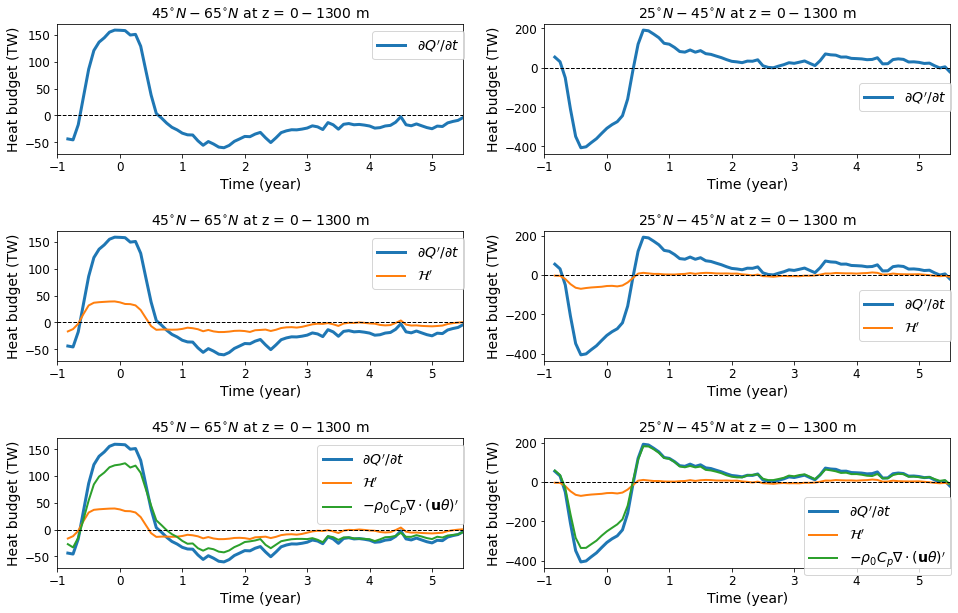

In [47]:
grid1 = plt.GridSpec(3, 2, wspace=0.2, hspace=0.6)
fig = plt.figure(figsize=[16,10])

HF = ds_45N_70N['hfds'].rolling(time=12, center=True).mean('time') / 1e12
Hor_flx = - (ds_45N_70N['Heat_Divergence_Horizontal_200'] + 
            ds_45N_70N['Heat_Divergence_Horizontal_1300']).rolling(time=12, center=True).mean('time') / 1e12
Ver_flx = - (ds_45N_70N['Heat_Divergence_Vertical_200'] + 
            ds_45N_70N['Heat_Divergence_Vertical_200']).rolling(time=12, center=True).mean('time') / 1e12
Q = HF + Hor_flx + Ver_flx

for i in range(0,3):
    ax = fig.add_subplot(grid1[i, 0])

    ax.plot(np.arange(len(Q.time))/12 - 16/12, Q, lw = 3., label=r'$\partial Q^{\prime}/\partial t$')
    
    if(i>0):
        ax.plot(np.arange(len(Q.time))/12 - 16/12, HF, lw = 2.,  
                label=r'$\mathcal{H}^{\prime}$')
    
    if(i>1):
        ax.plot(np.arange(len(Q.time))/12 - 16/12, Hor_flx + Ver_flx, lw = 2.,  
                label=r'$-\rho_0C_p\nabla\cdot({\bf{u}}\theta)^{\prime}$')
        
    ax.axhline(y=0, ls='--', lw=1, color='k')
    ax.set_xlabel('Time (year)', fontsize=14)
    ax.set_ylabel('Heat budget (TW)', fontsize=14)
    plt.legend(loc='upper right', bbox_to_anchor=(1.02, 1.0), fontsize=14)
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.title(r'$45^{\circ}N-65^{\circ}N$ at z = $0-1300$ m', fontsize=14)
    ax.set_xlim([-1., 5.5])
    
HF = ds_20N_45N['hfds'].rolling(time=12, center=True).mean('time') / 1e12
Hor_flx = - (ds_20N_45N['Heat_Divergence_Horizontal_200'] + 
            ds_20N_45N['Heat_Divergence_Horizontal_1300']).rolling(time=12, center=True).mean('time') / 1e12
Ver_flx = - (ds_20N_45N['Heat_Divergence_Vertical_200'] + 
            ds_20N_45N['Heat_Divergence_Vertical_200']).rolling(time=12, center=True).mean('time') / 1e12
Q = HF + Hor_flx + Ver_flx

for i in range(0,3):
    ax = fig.add_subplot(grid1[i, 1])

    ax.plot(np.arange(len(Q.time))/12 - 16/12, Q, lw = 3., label=r'$\partial Q^{\prime}/\partial t$')
    
    if(i>0):
        ax.plot(np.arange(len(Q.time))/12 - 16/12, HF, lw = 2.,  
                label=r'$\mathcal{H}^{\prime}$')
    
    if(i>1):
        ax.plot(np.arange(len(Q.time))/12 - 16/12, Hor_flx + Ver_flx, lw = 2.,  
                label=r'$-\rho_0C_p\nabla\cdot({\bf{u}}\theta)^{\prime}$')
        
    ax.axhline(y=0, ls='--', lw=1, color='k')
    ax.set_xlabel('Time (year)', fontsize=14)
    ax.set_ylabel('Heat budget (TW)', fontsize=14)
    plt.legend(loc='upper right', bbox_to_anchor=(1.02, 0.6), fontsize=14)
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.title(r'$25^{\circ}N-45^{\circ}N$ at z = $0-1300$ m', fontsize=14)
    ax.set_xlim([-1., 5.5])
    
#fig.savefig('/home/users/hkhatri/Plots/Figures_EGU_2022/Timeseries_NAOminus_Heat_content.pdf', dpi=150, bbox_inches='tight');
fig.savefig('/home/users/hkhatri/Plots/Figures_EGU_2022/Timeseries_NAOminus_Heat_content.png', dpi=300, bbox_inches='tight');

Text(0.5, 1.0, '$25^{\\circ}N-45^{\\circ}N$ at z below 1300 m')

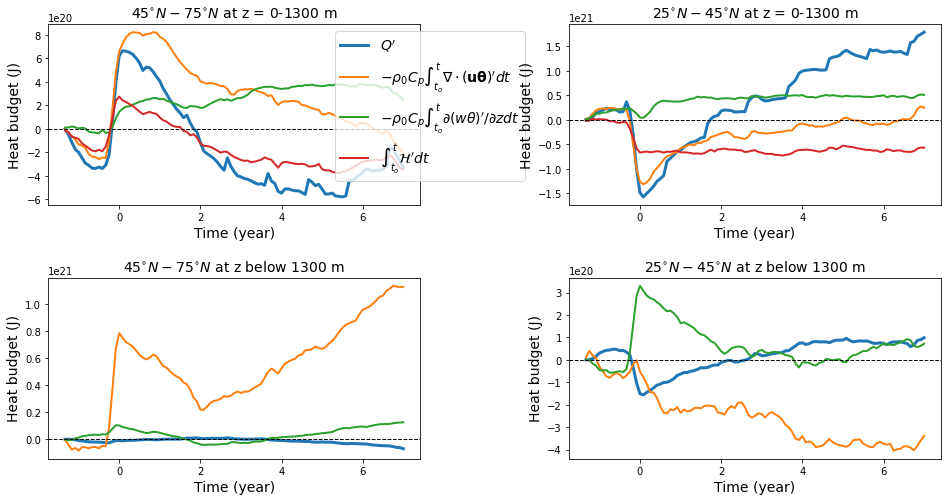

In [161]:
grid1 = plt.GridSpec(2, 2, wspace=0.4, hspace=0.4)
fig = plt.figure(figsize=[16,8])

ax = fig.add_subplot(grid1[0, 0])

Q = (ds_45N_70N['Heat_Content_200'] + ds_45N_70N['Heat_Content_1300'])
ax.plot(np.arange(len(Q.time))/12 - 16/12, Q- Q.isel(time=0), lw = 3., label=r'$Q^{\prime}$')

Hor_flx = - (ds_45N_70N['Heat_Divergence_Horizontal_200'] + 
             ds_45N_70N['Heat_Divergence_Horizontal_1300']).cumsum('time') * 30*3600.*24
ax.plot(np.arange(len(Q.time))/12 - 16/12, Hor_flx, lw = 2.,  label=r'$-\rho_0C_p\int_{t_o}^{t}\nabla\cdot({\bf{u}\theta})^{\prime} dt$')

Ver_flx = - (ds_45N_70N['Heat_Divergence_Vertical_200'] + 
             ds_45N_70N['Heat_Divergence_Vertical_1300']).cumsum('time') * 30*3600.*24
ax.plot(np.arange(len(Q.time))/12 - 16/12, Ver_flx, lw = 2.,  label=r'$-\rho_0C_p\int_{t_o}^{t}\partial ({w\theta})^{\prime}/\partial z dt$')

HF = ds_45N_70N['hfds'].cumsum('time') * 30*3600.*24
ax.plot(np.arange(len(Q.time))/12 - 16/12, HF, lw = 2.,  label=r'$\int_{t_o}^{t} \mathcal{H}^{\prime} dt$')

#ax.plot(HF - Hor_flx - Ver_flx)

ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_xlabel('Time (year)', fontsize=14)
ax.set_ylabel('Heat budget (J)', fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=14)
plt.title(r'$45^{\circ}N-75^{\circ}N$ at z = 0-1300 m', fontsize=14)

ax = fig.add_subplot(grid1[1, 0])

Q = (ds_45N_70N['Heat_Content'] - ds_45N_70N['Heat_Content_1300'] - ds_45N_70N['Heat_Content_200'])
ax.plot(np.arange(len(Q.time))/12 - 16/12, Q- Q.isel(time=0), lw = 3., label=r'$\int_A\partial Q^{\prime}/\partial t$')

Hor_flx = - (ds_45N_70N['Heat_Divergence_Horizontal'] - ds_45N_70N['Heat_Divergence_Horizontal_1300']
            - ds_45N_70N['Heat_Divergence_Horizontal_200']).cumsum('time') * 30*3600.*24
ax.plot(np.arange(len(Q.time))/12 - 16/12, Hor_flx, lw = 2.,  label=r'$-\rho_0C_p\int_A\nabla\cdot({\bf{u}\theta})^{\prime}$')

Ver_flx = - (ds_45N_70N['Heat_Divergence_Vertical'] - ds_45N_70N['Heat_Divergence_Vertical_1300'] -
            ds_45N_70N['Heat_Divergence_Vertical_200']).cumsum('time') * 30*3600.*24
ax.plot(np.arange(len(Q.time))/12 - 16/12, Ver_flx, lw = 2.,  label=r'$-\rho_0C_p\int_A\partial ({w\theta})^{\prime}/\partial z$')

#ax.plot(HF + Hor_flx + Ver_flx)

ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_xlabel('Time (year)', fontsize=14)
ax.set_ylabel('Heat budget (J)', fontsize=14)
#plt.legend(loc='lower right', fontsize=14)
plt.title(r'$45^{\circ}N-75^{\circ}N$ at z below 1300 m', fontsize=14)

ax = fig.add_subplot(grid1[0, 1])

Q = (ds_20N_45N['Heat_Content_200'] + ds_20N_45N['Heat_Content_1300'])
ax.plot(np.arange(len(Q.time))/12 - 16/12, Q- Q.isel(time=0), lw = 3., label=r'$Q^{\prime}$')

Hor_flx = - (ds_20N_45N['Heat_Divergence_Horizontal_200'] + 
             ds_20N_45N['Heat_Divergence_Horizontal_1300']).cumsum('time') * 30*3600.*24
ax.plot(np.arange(len(Q.time))/12 - 16/12, Hor_flx, lw = 2.,  label=r'$-\rho_0C_p\int_{t_o}^{t}\nabla\cdot({\bf{u}\theta})^{\prime} dt$')

Ver_flx = - (ds_20N_45N['Heat_Divergence_Vertical_200'] + 
             ds_20N_45N['Heat_Divergence_Vertical_1300']).cumsum('time') * 30*3600.*24
ax.plot(np.arange(len(Q.time))/12 - 16/12, Ver_flx, lw = 2.,  label=r'$-\rho_0C_p\int_{t_o}^{t}\partial ({w\theta})^{\prime}/\partial z dt$')

HF = ds_20N_45N['hfds'].cumsum('time') * 30*3600.*24
ax.plot(np.arange(len(Q.time))/12 - 16/12, HF, lw = 2.,  label=r'$\int_{t_o}^{t} \mathcal{H}^{\prime} dt$')

#ax.plot(HF - Hor_flx - Ver_flx)

ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_xlabel('Time (year)', fontsize=14)
ax.set_ylabel('Heat budget (J)', fontsize=14)
#plt.legend(loc='upper right', bbox_to_anchor=(0.5, 0.5), fontsize=14)
plt.title(r'$25^{\circ}N-45^{\circ}N$ at z = 0-1300 m', fontsize=14)

ax = fig.add_subplot(grid1[1, 1])

Q = (ds_20N_45N['Heat_Content'] - ds_20N_45N['Heat_Content_1300'] - ds_20N_45N['Heat_Content_200'])
ax.plot(np.arange(len(Q.time))/12 - 16/12, Q - Q.isel(time=0), lw = 3., label=r'$\int_A\partial Q^{\prime}/\partial t$')

Hor_flx = - (ds_20N_45N['Heat_Divergence_Horizontal'] - ds_20N_45N['Heat_Divergence_Horizontal_1300']
            - ds_20N_45N['Heat_Divergence_Horizontal_200']).cumsum('time') * 30*3600.*24
ax.plot(np.arange(len(Q.time))/12 - 16/12, Hor_flx, lw = 2.,  label=r'$-\rho_0C_p\int_A\nabla\cdot({\bf{u}\theta})^{\prime}$')

Ver_flx = - (ds_20N_45N['Heat_Divergence_Vertical'] - ds_20N_45N['Heat_Divergence_Vertical_1300'] -
            ds_20N_45N['Heat_Divergence_Vertical_200']).cumsum('time') * 30*3600.*24
ax.plot(np.arange(len(Q.time))/12 - 16/12, Ver_flx, lw = 2.,  label=r'$-\rho_0C_p\int_A\partial ({w\theta})^{\prime}/\partial z$')

#ax.plot(HF + Hor_flx + Ver_flx)

ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_xlabel('Time (year)', fontsize=14)
ax.set_ylabel('Heat budget (J)', fontsize=14)
#plt.legend(loc='lower right', fontsize=14)
plt.title(r'$25^{\circ}N-45^{\circ}N$ at z below 1300 m', fontsize=14)

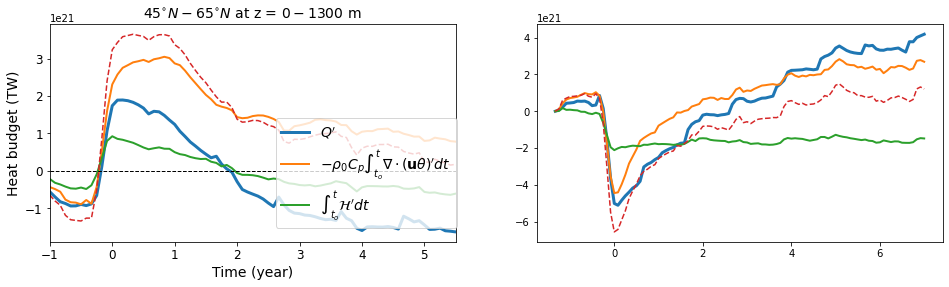

In [87]:
grid1 = plt.GridSpec(1, 2, wspace=0.2, hspace=0.6)
fig = plt.figure(figsize=[16,4])

ax = fig.add_subplot(grid1[0, 0])

Q = (ds_45N_70N['Heat_Content_200'] + ds_45N_70N['Heat_Content_1300'])

Heat_conv = (-(ds_45N_70N['Heat_Divergence_Horizontal_200'] + ds_45N_70N['Heat_Divergence_Horizontal_1300'] +
               ds_45N_70N['Heat_Divergence_Vertical_200'] + ds_45N_70N['Heat_Divergence_Vertical_1300']).cumsum('time') * 30*3600.*24)

HF = ds_45N_70N['hfds'].cumsum('time') * 30*3600.*24

ax.plot(np.arange(len(Q.time))/12 - 16/12, Q - Q.isel(time=0), lw = 3., label=r'$Q^{\prime}$')
ax.plot(np.arange(len(Q.time))/12 - 16/12, Heat_conv - Heat_conv.isel(time=0), lw = 2.,  
        label=r'$-\rho_0C_p\int_{t_o}^{t}\nabla\cdot({\bf{u}}\theta)^{\prime} dt$')
ax.plot(np.arange(len(Q.time))/12 - 16/12, HF - HF.isel(time=0), lw = 2.,  label=r'$\int_{t_o}^{t} \mathcal{H}^{\prime} dt$')

ax.plot(np.arange(len(Q.time))/12 - 16/12, Heat_conv - Heat_conv.isel(time=0) + HF - HF.isel(time=0), ls='--'); 

ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_xlabel('Time (year)', fontsize=14)
ax.set_ylabel('Heat budget (TW)', fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.02, 0.6), fontsize=14)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.title(r'$45^{\circ}N-65^{\circ}N$ at z = $0-1300$ m', fontsize=14)
ax.set_xlim([-1., 5.5])

ax = fig.add_subplot(grid1[0, 1])

Q = (ds_20N_45N['Heat_Content_200'] + ds_20N_45N['Heat_Content_1300'])

Heat_conv = (-(ds_20N_45N['Heat_Divergence_Horizontal_200'] + ds_20N_45N['Heat_Divergence_Horizontal_1300'] +
               ds_20N_45N['Heat_Divergence_Vertical_200'] + ds_20N_45N['Heat_Divergence_Vertical_1300']).cumsum('time') * 30*3600.*24)

HF = ds_20N_45N['hfds'].cumsum('time') * 30*3600.*24

ax.plot(np.arange(len(Q.time))/12 - 16/12, Q - Q.isel(time=0), lw = 3., label=r'$Q^{\prime}$')
ax.plot(np.arange(len(Q.time))/12 - 16/12, Heat_conv - Heat_conv.isel(time=0), lw = 2.,  
        label=r'$-\rho_0C_p\int_{t_o}^{t}\nabla\cdot({\bf{u}}\theta)^{\prime} dt$')
ax.plot(np.arange(len(Q.time))/12 - 16/12, HF - HF.isel(time=0), lw = 2.,  label=r'$\int_{t_o}^{t} \mathcal{H}^{\prime} dt$')

ax.plot(np.arange(len(Q.time))/12 - 16/12, Heat_conv - Heat_conv.isel(time=0) + HF - HF.isel(time=0), ls='--'); 

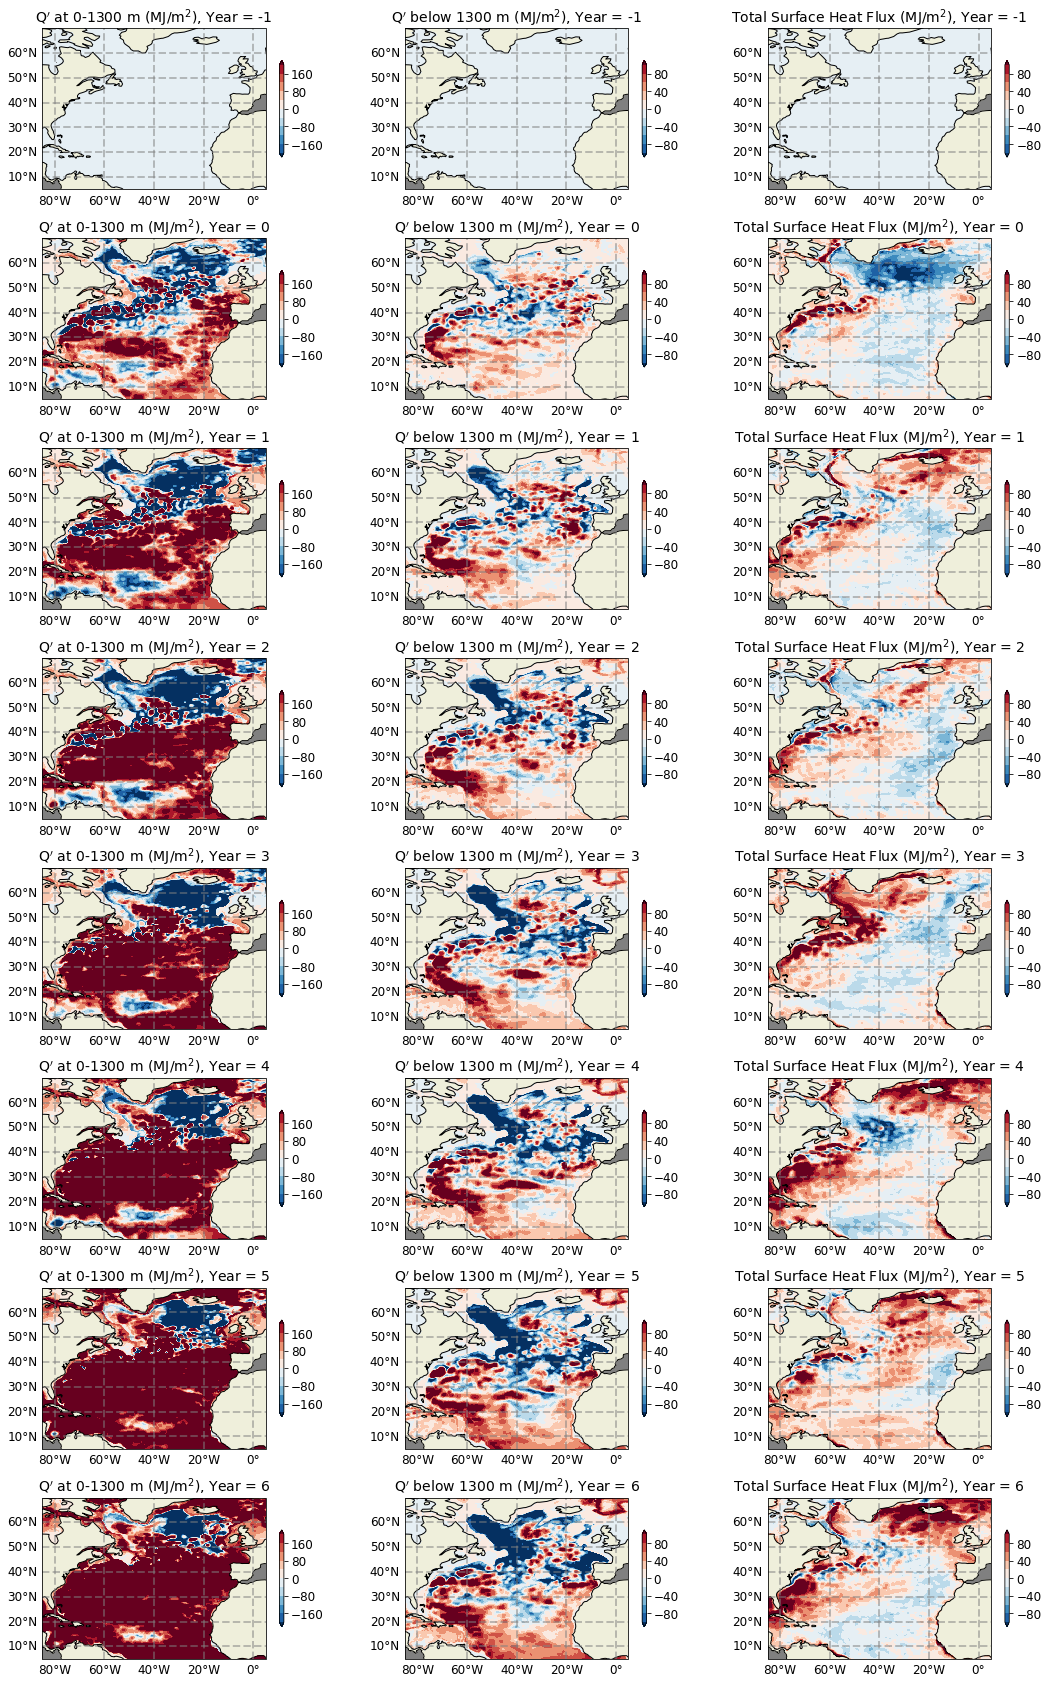

In [55]:
# Plot heat content anomalies with 12-month moving average for NAO+ + NAO- case.
# To see the asymmetry

lat_lon_ext = [-85., 5., 5., 70.]

grid1 = plt.GridSpec(8, 3, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=[18,30])

tmp_ds = (ds_NAOp + ds_NAOn).rolling(time=12, center=True).mean('time')

for i in range(0,8):
                 
    tmp = ((tmp_ds['Heat_Content_200'] + tmp_ds['Heat_Content_1300']).isel(time=i*12 + 6) - 
           (tmp_ds['Heat_Content_200'] + tmp_ds['Heat_Content_1300']).isel(time=6))/1e6
    tmp = tmp.where(ds_NAOp['mask_North_Atl_t']== 0.)
    ax = fig.add_subplot(grid1[i, 0], projection=ccrs.PlateCarree(),facecolor='grey')
    [p, cb] = plot_sec(ax, tmp, vmin=-200., vmax=200.,  lat_lon_ext = lat_lon_ext, levels = 11,
                       lon='longitude', lat='latitude', cmap='RdBu_r', title=r'Q$^{\prime}$ at 0-1300 m (MJ/m$^2$), Year = ' + str(i-1))
    
    tmp = ((tmp_ds['Heat_Content'] - tmp_ds['Heat_Content_1300'] - tmp_ds['Heat_Content_200']).isel(time=i*12 + 6) -
           (tmp_ds['Heat_Content'] - tmp_ds['Heat_Content_1300'] - tmp_ds['Heat_Content_200']).isel(time=6))/1e6
    tmp = tmp.where(ds_NAOp['mask_North_Atl_t']== 0.)
    ax = fig.add_subplot(grid1[i, 1], projection=ccrs.PlateCarree(),facecolor='grey')
    [p, cb] = plot_sec(ax, tmp, vmin=-100., vmax=100.,  lat_lon_ext = lat_lon_ext, levels = 11,
                       lon='longitude', lat='latitude', cmap='RdBu_r', title=r'Q$^{\prime}$ below 1300 m (MJ/m$^2$), Year = ' + str(i-1))
    
    #tmp = tmp_ds['hfds'].isel(time=i*12 + 6)
    tmp = ((ds_NAOn['hfds'] + ds_NAOp['hfds']).isel(time=slice(int(i*12), int(i*12 + 6 + 6))).sum('time') * 12 
           - (ds_NAOn['hfds'] + ds_NAOp['hfds']).isel(time=slice(0, 12)).sum('time') * 12) * 3600. * 24. /1e6 # heat flux integrated within a year
    tmp = tmp.where(ds_NAOp['mask_North_Atl_t']== 0.)
    ax = fig.add_subplot(grid1[i, 2], projection=ccrs.PlateCarree(),facecolor='grey')
    [p, cb] = plot_sec(ax, tmp, vmin=-100., vmax=100.,  lat_lon_ext = lat_lon_ext, levels = 11,
                       lon='longitude', lat='latitude', cmap='RdBu_r', title=r'Total Surface Heat Flux (MJ/m$^2$), Year = ' + str(i-1))
    
#fig.savefig('/home/users/hkhatri/Plots/Figures_EGU_2022/Snapshot_NAOminus_Heat_content.pdf',
#            dpi=150,bbox_inches='tight');

#### Horizontal convergence term

Horizontal heat convergence term does not seem to agree with the other budget terms. Residual is too large and even the sign of the term is not always correct. Let's try a different approach. 

$$ \int_z\int_x\int_y[\frac{\partial(u\theta)^{\prime}}{\partial x} + \int_z\int_x\int_y[\frac{\partial(v\theta)^{\prime}}{\partial y} = \int_z\int_x [(v\theta)^{\prime}|_{y_n} - (v\theta)^{\prime}|_{y_s}]$$

We have northward heat transport diagnostics saved at different levels. Let's try those for computing horizontal convergence term.

In [70]:
ppdir = "/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/Temp/"

ds = []

for r in range(0,4):
    
    d = xr.open_dataset(ppdir + "Overturning_Heat_Transport_r" + str(r+1) + ".nc", chunks={'start_year':1})
    
    ds.append(d.get(['MHT_z', 'MHT_overturning_z', 'latitude']))
    
ds = xr.concat(ds, dim='r')

# read drift data

ppdir1 = "/gws/nopw/j04/snapdragon/hkhatri/Data_Drift/psi_sigma/"

ds_drift = []

for r in range(0,4):
    
    ds1 = []
    
    for lead_year in range(0, 11):
        
        d = xr.open_dataset(ppdir1 + "Drift_Overturning_r" + str(r+1) + "_Lead_Year_" +
                            str(lead_year + 1) + ".nc", decode_times= False)
        
        d = d.assign(time = np.arange(lead_year*12, 12*lead_year + 
                                      np.minimum(12, len(d['time'])), 1))
        
        ds1.append(d.get(['MHT_z', 'MHT_overturning_z', 'latitude']))
        
    ds1 = xr.concat(ds1, dim='time')
    
    ds_drift.append(ds1)
    
ds_drift = xr.concat(ds_drift, dim='r')
    
print(ds_drift, ds)

<xarray.Dataset>
Dimensions:            (r: 4, time: 125, lev: 75, j_c: 450)
Coordinates:
  * j_c                (j_c) int32 699 700 701 702 703 ... 1145 1146 1147 1148
  * lev                (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time               (time) int64 0 1 2 3 4 5 6 ... 119 120 121 122 123 124
Dimensions without coordinates: r
Data variables:
    MHT_z              (r, time, lev, j_c) float64 7.579e+13 7.393e+13 ... 0.0
    MHT_overturning_z  (r, time, lev, j_c) float64 7.588e+13 7.152e+13 ... 0.0
    latitude           (r, time, j_c) float32 4.121 4.371 4.62 ... 75.82 75.9 <xarray.Dataset>
Dimensions:            (r: 4, start_year: 57, time: 125, lev: 75, j_c: 450)
Coordinates:
  * j_c                (j_c) int32 699 700 701 702 703 ... 1145 1146 1147 1148
  * lev                (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * start_year         (start_year) int64 1960 1961 1962 1963 ... 2014 2015 2016
Dimensions without coordinates: r, time
D

In [71]:
print(count_NAOn, count_NAOp)

69 49


In [72]:
ds_anom = ds.drop('start_year') - ds_drift.drop('time')

ds_HT_NAOp = []
ds_HT_NAOn = []

for ind in range(4,13,4):
    
    tmp1 = ds_anom.where(NAO_season.isel(time=ind).drop('time') >= NAO_cut)
    tmp1 = tmp1.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5))

    ds_HT_NAOp.append(tmp1)
    
    tmp1 = ds_anom.where(NAO_season.isel(time=ind).drop('time') <= -NAO_cut)
    tmp1 = tmp1.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5))

    ds_HT_NAOn.append(tmp1)
    
ds_HT_NAOp = xr.concat(ds_HT_NAOp,dim='case')
ds_HT_NAOn = xr.concat(ds_HT_NAOn,dim='case')

ds_HT_NAOp = ds_HT_NAOp.sum(['start_year','r','case']) / count_NAOp
ds_HT_NAOn = ds_HT_NAOn.sum(['start_year','r','case']) / count_NAOn

#ds_HT_NAOp = ds_HT_NAOp.isel(j_c=slice(0,340)) # to get values upto 65N

ds_HT_NAOp = ds_HT_NAOp.drop('latitude').assign_coords(j_c=ds['latitude'].isel(r=0,start_year=0)).isel(j_c=slice(0,303))
ds_HT_NAOn = ds_HT_NAOn.drop('latitude').assign_coords(j_c=ds['latitude'].isel(r=0,start_year=0)).isel(j_c=slice(0,303))

print(ds_HT_NAOp)

<xarray.Dataset>
Dimensions:            (j_c: 303, lev: 75, time: 101)
Coordinates:
  * j_c                (j_c) float32 4.121 4.371 4.62 ... 59.86 60.13 60.29
  * lev                (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    start_year         int64 1960
Dimensions without coordinates: time
Data variables:
    MHT_z              (time, lev, j_c) float64 dask.array<chunksize=(101, 75, 303), meta=np.ndarray>
    MHT_overturning_z  (time, lev, j_c) float64 dask.array<chunksize=(101, 75, 303), meta=np.ndarray>


In [37]:
HT_25_45 = (ds_HT_NAOp['MHT_z'].sel(j_c=45., method='nearest') 
            - ds_HT_NAOp['MHT_z'].sel(j_c=25., method='nearest')).isel(lev=slice(0,49)).sum('lev')

%time HT_25_45 = HT_25_45.compute()

print(HT_25_45)

CPU times: user 54.7 s, sys: 1min 8s, total: 2min 2s
Wall time: 37.8 s
<xarray.DataArray 'MHT_z' (time: 101)>
array([ 9.23718155e+13,  5.47047772e+13,  1.60278683e+13,  3.98172520e+13,
        1.44034386e+14,  1.26133537e+13,  3.50206495e+13,  9.07328890e+12,
       -3.98000159e+13, -5.57948776e+13, -5.23582605e+13, -3.35878091e+13,
       -2.48014365e+13, -3.27059601e+14, -6.05572924e+14, -5.72751813e+14,
       -2.01926174e+14,  4.75230459e+13,  8.93669993e+12,  1.22417647e+14,
        4.77181629e+13,  3.93648477e+13,  3.60488701e+13,  5.91000029e+13,
        8.43592287e+13,  3.69940032e+13,  5.05027385e+13, -1.53845071e+14,
        8.58885047e+13,  7.71026886e+13, -1.72963104e+13,  5.44967645e+13,
        3.67252888e+13, -1.72245221e+12,  7.51234498e+12,  4.67736373e+13,
       -3.98357901e+13,  2.47372329e+12,  8.35993020e+13,  1.83163718e+13,
        6.57298068e+13, -7.51071603e+12, -2.69742858e+12,  1.82769733e+13,
       -1.76366003e+12,  3.70450063e+13,  3.73477909e+13, -2.9477

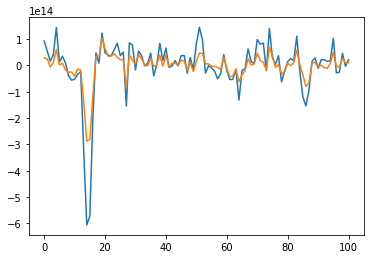

In [44]:
plt.plot(HT_25_45)
plt.plot(ds_20N_45N['Heat_Divergence_Horizontal_200'] + ds_20N_45N['Heat_Divergence_Horizontal_1300'])

CPU times: user 50.7 s, sys: 59.3 s, total: 1min 49s
Wall time: 34.6 s


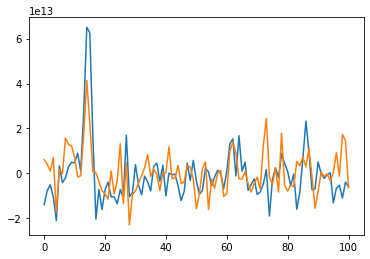

In [45]:
HT_25_45_deep = (ds_HT_NAOp['MHT_z'].sel(j_c=45., method='nearest') 
                 - ds_HT_NAOp['MHT_z'].sel(j_c=25., method='nearest')).isel(lev=slice(49,75)).sum('lev')

%time HT_25_45_deep = HT_25_45_deep.compute()


plt.plot(HT_25_45_deep)
plt.plot(ds_20N_45N['Heat_Divergence_Horizontal'] - ds_20N_45N['Heat_Divergence_Horizontal_200'] - ds_20N_45N['Heat_Divergence_Horizontal_1300'])

CPU times: user 50.5 s, sys: 58 s, total: 1min 48s
Wall time: 33.8 s


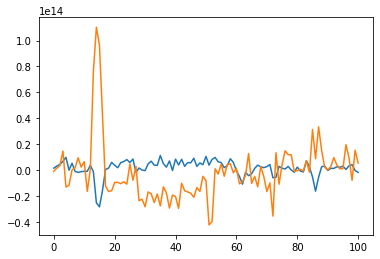

In [46]:
HT_45_60_deep = (ds_HT_NAOp['MHT_z'].sel(j_c=60., method='nearest') 
                 - ds_HT_NAOp['MHT_z'].sel(j_c=45., method='nearest')).isel(lev=slice(49,75)).sum('lev')

%time HT_45_60_deep = HT_45_60_deep.compute()


plt.plot(HT_45_60_deep)
plt.plot(ds_45N_70N['Heat_Divergence_Horizontal'] - ds_45N_70N['Heat_Divergence_Horizontal_200'] - ds_45N_70N['Heat_Divergence_Horizontal_1300'])

CPU times: user 53.7 s, sys: 1min 7s, total: 2min
Wall time: 38.1 s


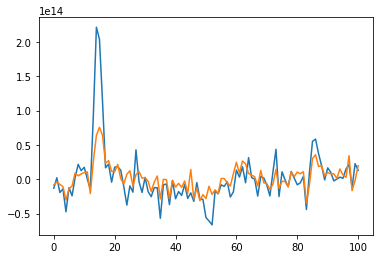

In [47]:
HT_45_60 = (ds_HT_NAOp['MHT_z'].sel(j_c=60., method='nearest') 
                 - ds_HT_NAOp['MHT_z'].sel(j_c=45., method='nearest')).isel(lev=slice(0,49)).sum('lev')

%time HT_45_60 = HT_45_60.compute()

plt.plot(HT_45_60)
plt.plot(ds_45N_70N['Heat_Divergence_Horizontal_200'] + ds_45N_70N['Heat_Divergence_Horizontal_1300'])

In [73]:
# Northward heat tranport at 45N

%time HTp_1300 = ds_HT_NAOp.sel(j_c=45., method='nearest').isel(lev=slice(31,49)).sum('lev').compute()
%time HTn_1300 = ds_HT_NAOn.sel(j_c=45., method='nearest').isel(lev=slice(31,49)).sum('lev').compute()

%time HTp_200 = ds_HT_NAOp.sel(j_c=45., method='nearest').isel(lev=slice(0,31)).sum('lev').compute()
%time HTn_200 = ds_HT_NAOn.sel(j_c=45., method='nearest').isel(lev=slice(0,31)).sum('lev').compute()

CPU times: user 1min 52s, sys: 2min 6s, total: 3min 58s
Wall time: 1min 12s
CPU times: user 1min 42s, sys: 1min 37s, total: 3min 19s
Wall time: 1min
CPU times: user 1min 46s, sys: 1min 43s, total: 3min 30s
Wall time: 1min 2s
CPU times: user 1min 46s, sys: 1min 47s, total: 3min 33s
Wall time: 1min 3s


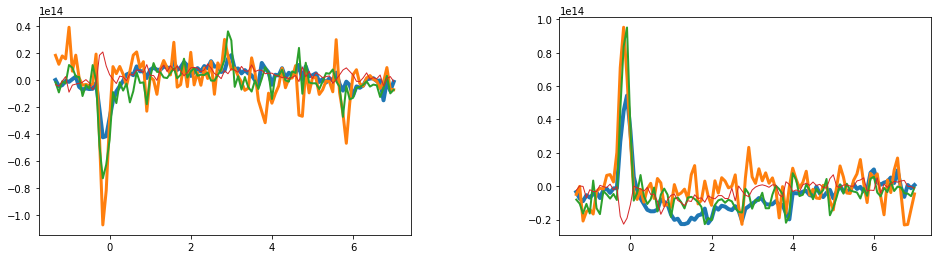

In [22]:
grid1 = plt.GridSpec(1, 2, wspace=0.4, hspace=0.4)
fig = plt.figure(figsize=[16,4])

ax = fig.add_subplot(grid1[0, 0])
ax.plot(np.arange(len(HTp_200.time))/12 - 16/12, HTp_200['MHT_z'] - HTp_200['MHT_overturning_z'], lw=4.)
ax.plot(np.arange(len(HTp_200.time))/12 - 16/12, HTp_200['MHT_overturning_z'], lw=3.)
ax.plot(np.arange(len(HTp_200.time))/12 - 16/12, HTp_1300['MHT_z'] - HTp_1300['MHT_overturning_z'], lw=2.)
ax.plot(np.arange(len(HTp_200.time))/12 - 16/12, HTp_1300['MHT_overturning_z'], lw=1.)

ax = fig.add_subplot(grid1[0, 1])
ax.plot(np.arange(len(HTn_200.time))/12 - 16/12, HTn_200['MHT_z'] - HTn_200['MHT_overturning_z'], lw=4.)
ax.plot(np.arange(len(HTn_200.time))/12 - 16/12, HTn_200['MHT_overturning_z'], lw=3.)
ax.plot(np.arange(len(HTp_200.time))/12 - 16/12, HTn_1300['MHT_z'] - HTn_1300['MHT_overturning_z'], lw=2.)
ax.plot(np.arange(len(HTp_200.time))/12 - 16/12, HTn_1300['MHT_overturning_z'], lw=1.)

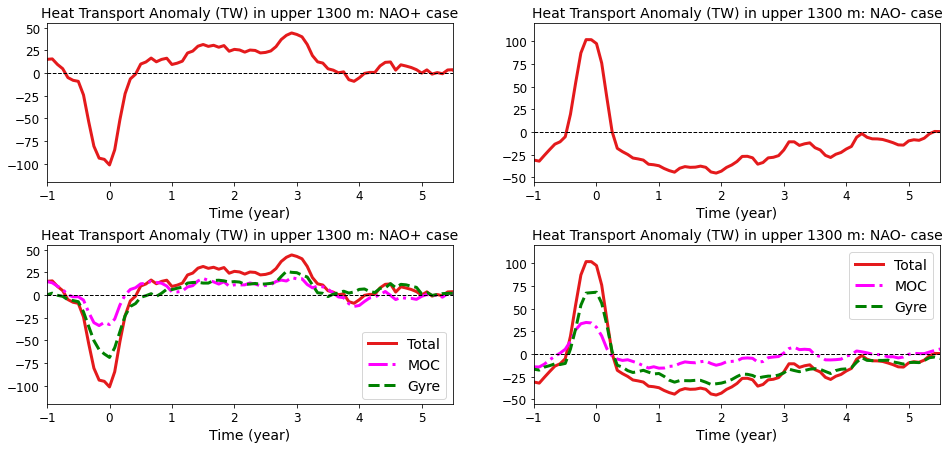

In [84]:
col = plt.cm.Set1(np.linspace(0.,0.55,3))

grid1 = plt.GridSpec(2, 2, wspace=0.2, hspace=0.4)
fig = plt.figure(figsize=[16,7])

ax = fig.add_subplot(grid1[0, 0])
tmp = (HTp_200['MHT_z'] + HTp_1300['MHT_z']).rolling(time=6, center=True).mean('time') /1e12
ax.plot(np.arange(len(HTp_200.time))/12 - 16/12, tmp, lw=3., color=col[0])
ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_xlabel(r'Time (year)', fontsize=14)
#plt.legend(loc='upper right', bbox_to_anchor=(1.02, 1.02), fontsize=14)
plt.title('Heat Transport Anomaly (TW) in upper 1300 m: NAO+ case', fontsize=14)
plt.yticks(fontsize = 12);
plt.xticks(fontsize = 12);
ax.set_ylim([-120, 55])
ax.set_xlim([-1., 5.5])

ax = fig.add_subplot(grid1[1, 0])
tmp = (HTp_200['MHT_z'] + HTp_1300['MHT_z']).rolling(time=6, center=True).mean('time') /1e12
ax.plot(np.arange(len(HTp_200.time))/12 - 16/12, tmp, lw=3., label='Total', color=col[0])
tmp = (HTp_200['MHT_overturning_z'] + HTp_1300['MHT_overturning_z']).rolling(time=6, center=True).mean('time') /1e12
ax.plot(np.arange(len(HTp_200.time))/12 - 16/12, tmp, lw=3., ls ='-.', label='MOC', color='magenta')
tmp = (HTp_200['MHT_z'] + HTp_1300['MHT_z'] - HTp_200['MHT_overturning_z'] - HTp_1300['MHT_overturning_z']).rolling(time=6, center=True).mean('time') /1e12
ax.plot(np.arange(len(HTp_200.time))/12 - 16/12, tmp, lw=3., ls ='--', label='Gyre', color='green')
ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_xlabel(r'Time (year)', fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1., 0.5), fontsize=14)
plt.title('Heat Transport Anomaly (TW) in upper 1300 m: NAO+ case', fontsize=14)
plt.yticks(fontsize = 12);
plt.xticks(fontsize = 12);
ax.set_ylim([-120, 55])
ax.set_xlim([-1., 5.5])

ax = fig.add_subplot(grid1[0, 1])
tmp = (HTn_200['MHT_z'] + HTn_1300['MHT_z']).rolling(time=6, center=True).mean('time') /1e12
ax.plot(np.arange(len(HTn_200.time))/12 - 16/12, tmp, lw=3., color=col[0])
ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_xlabel(r'Time (year)', fontsize=14)
#plt.legend(loc='upper right', bbox_to_anchor=(1.02, 1.02), fontsize=14)
plt.title('Heat Transport Anomaly (TW) in upper 1300 m: NAO- case', fontsize=14)
plt.yticks(fontsize = 12);
plt.xticks(fontsize = 12);
ax.set_ylim([-55, 120])
ax.set_xlim([-1., 5.5])

ax = fig.add_subplot(grid1[1, 1])
tmp = (HTn_200['MHT_z'] + HTn_1300['MHT_z']).rolling(time=6, center=True).mean('time') /1e12
ax.plot(np.arange(len(HTp_200.time))/12 - 16/12, tmp, lw=3., label='Total', color=col[0])
tmp = (HTn_200['MHT_overturning_z'] + HTn_1300['MHT_overturning_z']).rolling(time=6, center=True).mean('time') /1e12
ax.plot(np.arange(len(HTp_200.time))/12 - 16/12, tmp, lw=3., ls ='-.', label='MOC', color='magenta')
tmp = (HTn_200['MHT_z'] + HTn_1300['MHT_z'] - HTn_200['MHT_overturning_z'] - HTn_1300['MHT_overturning_z']).rolling(time=6, center=True).mean('time') /1e12
ax.plot(np.arange(len(HTp_200.time))/12 - 16/12, tmp, lw=3., ls ='--', label='Gyre', color='green')
ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_xlabel(r'Time (year)', fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1., 1.), fontsize=14)
plt.title('Heat Transport Anomaly (TW) in upper 1300 m: NAO- case', fontsize=14)
plt.yticks(fontsize = 12);
plt.xticks(fontsize = 12);
ax.set_ylim([-55, 120])
ax.set_xlim([-1., 5.5])

#fig.savefig('/home/users/hkhatri/Plots/Figures_EGU_2022/Timeseries_Anomaly_Heat_Transport.pdf', dpi=150, bbox_inches='tight');

fig.savefig('/home/users/hkhatri/Plots/Figures_EGU_2022/Timeseries_Anomaly_Heat_Transport.png', dpi=300, bbox_inches='tight');

(-220.0, 110.0)

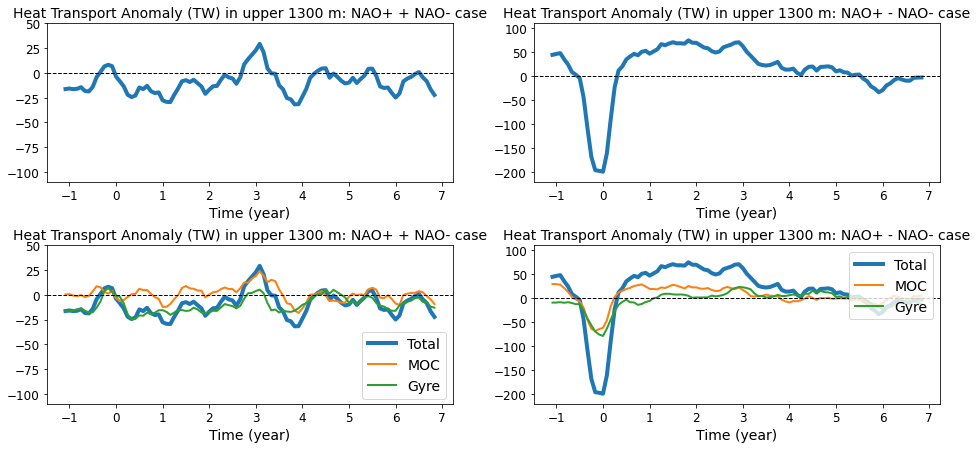

In [16]:
# To see assymetry between NAO+ and NAO- cases (plot sum and substarction of composites of NAO+ NAO-

grid1 = plt.GridSpec(2, 2, wspace=0.2, hspace=0.4)
fig = plt.figure(figsize=[16,7])

ax = fig.add_subplot(grid1[0, 0])
tmp = (HTp_200['MHT_z'] + HTp_1300['MHT_z'] + HTn_200['MHT_z'] + HTn_1300['MHT_z']).rolling(time=6, center=True).mean('time') /1e12
ax.plot(np.arange(len(HTp_200.time))/12 - 16/12, tmp, lw=4.)
ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_xlabel(r'Time (year)', fontsize=14)
#plt.legend(loc='upper right', bbox_to_anchor=(1.02, 1.02), fontsize=14)
plt.title('Heat Transport Anomaly (TW) in upper 1300 m: NAO+ + NAO- case', fontsize=14)
plt.yticks(fontsize = 12);
plt.xticks(fontsize = 12);
ax.set_ylim([-110, 50])

ax = fig.add_subplot(grid1[1, 0])
tmp = (HTp_200['MHT_z'] + HTp_1300['MHT_z'] + HTn_200['MHT_z'] + HTn_1300['MHT_z']).rolling(time=6, center=True).mean('time') /1e12
ax.plot(np.arange(len(HTp_200.time))/12 - 16/12, tmp, lw=4., label='Total')

tmp = (HTp_200['MHT_overturning_z'] + HTp_1300['MHT_overturning_z'] + 
       HTn_200['MHT_overturning_z'] + HTn_1300['MHT_overturning_z']).rolling(time=6, center=True).mean('time') /1e12
ax.plot(np.arange(len(HTp_200.time))/12 - 16/12, tmp, lw=2., label='MOC')

tmp = (HTp_200['MHT_z'] + HTp_1300['MHT_z'] - HTp_200['MHT_overturning_z'] - HTp_1300['MHT_overturning_z']
      + HTn_200['MHT_z'] + HTn_1300['MHT_z'] - HTn_200['MHT_overturning_z'] - HTn_1300['MHT_overturning_z']).rolling(time=6, center=True).mean('time') /1e12
ax.plot(np.arange(len(HTp_200.time))/12 - 16/12, tmp, lw=2., label='Gyre')

ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_xlabel(r'Time (year)', fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1., 0.5), fontsize=14)
plt.title('Heat Transport Anomaly (TW) in upper 1300 m: NAO+ + NAO- case', fontsize=14)
plt.yticks(fontsize = 12);
plt.xticks(fontsize = 12);
ax.set_ylim([-110, 50])

ax = fig.add_subplot(grid1[0, 1])
tmp = (HTp_200['MHT_z'] + HTp_1300['MHT_z'] - HTn_200['MHT_z'] - HTn_1300['MHT_z']).rolling(time=6, center=True).mean('time') /1e12
ax.plot(np.arange(len(HTn_200.time))/12 - 16/12, tmp, lw=4.)
ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_xlabel(r'Time (year)', fontsize=14)
#plt.legend(loc='upper right', bbox_to_anchor=(1.02, 1.02), fontsize=14)
plt.title('Heat Transport Anomaly (TW) in upper 1300 m: NAO+ - NAO- case', fontsize=14)
plt.yticks(fontsize = 12);
plt.xticks(fontsize = 12);
ax.set_ylim([-220, 110])

ax = fig.add_subplot(grid1[1, 1])
tmp = (HTp_200['MHT_z'] + HTp_1300['MHT_z'] - HTn_200['MHT_z'] - HTn_1300['MHT_z']).rolling(time=6, center=True).mean('time') /1e12
ax.plot(np.arange(len(HTp_200.time))/12 - 16/12, tmp, lw=4., label='Total')

tmp = (HTp_200['MHT_overturning_z'] + HTp_1300['MHT_overturning_z'] - 
       HTn_200['MHT_overturning_z'] - HTn_1300['MHT_overturning_z']).rolling(time=6, center=True).mean('time') /1e12
ax.plot(np.arange(len(HTp_200.time))/12 - 16/12, tmp, lw=2., label='MOC')

tmp = (HTp_200['MHT_z'] + HTp_1300['MHT_z'] - HTp_200['MHT_overturning_z'] - HTp_1300['MHT_overturning_z']
      - HTn_200['MHT_z'] + HTn_1300['MHT_z'] + HTn_200['MHT_overturning_z'] + HTn_1300['MHT_overturning_z']).rolling(time=6, center=True).mean('time') /1e12
ax.plot(np.arange(len(HTp_200.time))/12 - 16/12, tmp, lw=2., label='Gyre')

ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_xlabel(r'Time (year)', fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1., 1.), fontsize=14)
plt.title('Heat Transport Anomaly (TW) in upper 1300 m: NAO+ - NAO- case', fontsize=14)
plt.yticks(fontsize = 12);
plt.xticks(fontsize = 12);
ax.set_ylim([-220, 110])

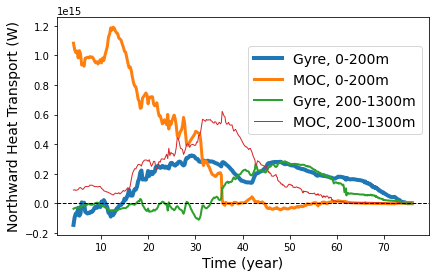

In [26]:
grid1 = plt.GridSpec(1, 2, wspace=0.4, hspace=0.4)
fig = plt.figure(figsize=[16,4])

ax = fig.add_subplot(grid1[0, 0])
ax.plot(ds['latitude'].isel(r=0,start_year=0), (ds_drift['MHT_z']-ds_drift['MHT_overturning_z']).isel(lev=slice(0,31)).sum('lev').mean(['time','r']), lw=4.,
       label ='Gyre, 0-200m')
ax.plot(ds['latitude'].isel(r=0,start_year=0), ds_drift['MHT_overturning_z'].isel(lev=slice(0,31)).sum('lev').mean(['time','r']), lw=3.,
       label ='MOC, 0-200m')

ax.plot(ds['latitude'].isel(r=0,start_year=0), (ds_drift['MHT_z']-ds_drift['MHT_overturning_z']).isel(lev=slice(31,49)).sum('lev').mean(['time','r']), lw=2.,
       label ='Gyre, 200-1300m')
ax.plot(ds['latitude'].isel(r=0,start_year=0), ds_drift['MHT_overturning_z'].isel(lev=slice(31,49)).sum('lev').mean(['time','r']), lw=1.,
       label ='MOC, 200-1300m')
ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_xlabel('Time (year)', fontsize=14)
ax.set_ylabel('Northward Heat Transport (W)', fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1., 0.9), fontsize=14)

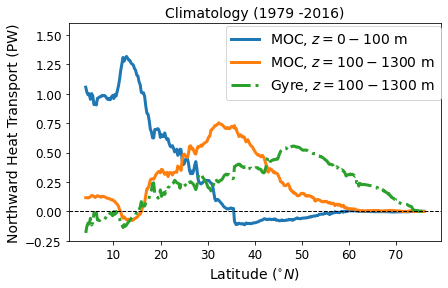

In [10]:
grid1 = plt.GridSpec(1, 2, wspace=0.4, hspace=0.4)
fig = plt.figure(figsize=[16,4])

ax = fig.add_subplot(grid1[0, 0])
tmp =ds_drift['MHT_overturning_z'].isel(lev=slice(0,24)).sum('lev').mean(['time','r']) / 1e15
ax.plot(ds['latitude'].isel(r=0,start_year=0), tmp, lw=3., label =r'MOC, $z=0-$100 m')

tmp = ds_drift['MHT_overturning_z'].isel(lev=slice(24,49)).sum('lev').mean(['time','r']) /1e15
ax.plot(ds['latitude'].isel(r=0,start_year=0), tmp, lw=3., label =r'MOC, $z=100-1300$ m')

tmp = (ds_drift['MHT_z']-ds_drift['MHT_overturning_z']).isel(lev=slice(0,49)).sum('lev').mean(['time','r']) / 1e15
ax.plot(ds['latitude'].isel(r=0,start_year=0), tmp, lw=3., ls = '-.', label ='Gyre, $z=100-1300$ m')

ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_xlabel(r'Latitude ($^{\circ}N$)', fontsize=14)
ax.set_ylabel('Northward Heat Transport (PW)', fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.02, 1.02), fontsize=14)
plt.title('Climatology (1979 -2016)', fontsize=14)
plt.yticks(fontsize = 12);
plt.xticks(fontsize = 12);
ax.set_ylim([-0.25, 1.6])

fig.savefig('/home/users/hkhatri/Plots/Figures_EGU_2022/Cimatology_Heat_Transport.pdf', dpi=150, bbox_inches='tight');

In [30]:
ds_drift.lev.values[30]

199.7899627685547